In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time
import random

In [2]:
class StepLogger():
    def __init__(self,capacity):
        self.tensor_datas = {}        
        self.capacity = capacity
        self.added_labels = []
        
    
    def add_info(self,tensor_data,tensor_label):
        if tensor_label not in self.added_labels:
            self.added_labels.append( tensor_label )
        
        if tensor_label in self.tensor_datas.keys():
            current_arr = self.tensor_datas.get(tensor_label)
            if len(current_arr) < self.capacity:
                current_arr = self.tensor_datas.get(tensor_label, [])
                current_arr.append(tensor_data)
        else:
            self.tensor_datas[tensor_label] = [tensor_data]
    
    def get_default_summary(self,show_data=False,summary_count=1):
        self.get_summary(self.added_labels,show_data,summary_count)
        
    def get_summary(self,labels,show_data=False,summary_count=1):
        print("summary_count",summary_count,"   self.capacity ",self.capacity)
        count = 0
        values = []
        for i in range(summary_count):
            print(i," ------------------------------------------------")
            for l in labels:
                label_data = self.tensor_datas.get(l)[i]
                values.append(label_data)
                print(l)
                if torch.is_tensor(label_data):
                    print( list(label_data.size() ) )
                if not show_data and not torch.is_tensor(label_data):
                    print(label_data)
                if show_data:    
                    print(label_data)
        return values              
                    
loggers = {}                    
current_logger = StepLogger(100)   
def add_new_logger(logger_label):
    global current_logger
    if logger_label in loggers.keys() :
        print("using existing logger")
        current_logger = loggers[logger_label]
    else:    
        loggers[logger_label]  = StepLogger(20)
        current_logger = loggers[logger_label]
    

def add_infos(datas,labels,labels_prefix=""):
    #print( id(current_logger))
    for i in range(len(datas)):
        final_label = labels_prefix+"@"+labels[i]
        current_logger.add_info(datas[i],final_label.strip())
    
#add_info   tensor_data,tensor_label                  currentLogger.get_default_summary(show_data=False)

In [3]:
#!pip install torchtext
#!pip install spacy

In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
#spacy_en = spacy.load('en')
spacy_en = spacy.load("en_core_web_sm")

In [6]:
#tok = spacy.load("en_core_web_sm")
#tokde = spacy.load("de_core_news_sm")
import de_core_news_sm
spacy_de = de_core_news_sm.load()

In [7]:
spacy_de.tokenizer("i mochte lesen")

i mochte lesen

In [8]:
#!python -m spacy download de


In [9]:
#spacy_de = spacy.load('de')

In [10]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [11]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

In [12]:
tabular_set = torchtext.data.TabularDataset(
path='D:/data8/eng_de3.csv', format='csv',
fields=[('src', SRC),
        ('trg', TRG)])

In [13]:
#dump a sample
print(tabular_set[0].src)
print(tabular_set[0].trg)


['i', 'want', 'to', 'eat', 'bread']
['ich', 'mochten', 'brot', 'essen']


In [14]:
#TODO can generate different items for each
#Real line in tutorial
#train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), fields = (SRC, TRG))
train_data, valid_data, test_data = tabular_set ,tabular_set, tabular_set

In [15]:
#all of our vocublary is used at least 2 times
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

In [17]:
#our tranining size is so small so batch size will also be small
BATCH_SIZE = 8


In [18]:
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_key = lambda x:  len(x.src),
     device = device)


In [19]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask,is_appy_attention):
        
        #src = [batch size, src len]
        #src_mask = [batch size, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        add_infos([src,pos],["src","pos"],"Encoder")   
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask,is_appy_attention)
            
        add_infos([src],["src_final"],"Encoder")    
        #src = [batch size, src len, hid dim]
            
        return src

In [20]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device,"encoder")
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask,is_appy_attention):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, src len]
                
        #self attention
        _src, sattention = self.self_attention(src, src, src,is_appy_attention, src_mask) #return x, attention
        
        #dropout, residual connection and layer norm
        src2 = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src2 = self.positionwise_feedforward(src2)
        
        #dropout, residual and layer norm
        src3 = self.ff_layer_norm(src + self.dropout(_src2))
        
        add_infos([_src,src2,_src2,src3,src_mask,sattention],["_src","src2","_src2","src3","src_mask","sattention"],"EncoderLayer")
        #src = [batch size, src len, hid dim]
        
        return src3

In [21]:
class MultiHeadAttentionLayer(nn.Module):
    #since this layer is common while logging there must be a label to differantiate labels
    def __init__(self, hid_dim, n_heads, dropout, device,layer_label):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        #TODO head_dim is encoding per head so ,hid_dim must divide n_heads
        self.head_dim = hid_dim // n_heads
        self.layer_label = layer_label
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        add_infos([self.hid_dim,self.n_heads,self.head_dim],["hid_dim","n_heads","head_dim"],self.layer_label)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value,is_appy_attention, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        add_infos([Q,K,V],["Q","K","V"],self.layer_label)
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
        
        ### attention is a weight over dimensions
        if not is_appy_attention:
            print("old attention",attention.shape)
            print("old attention",attention)
        
            #normally distributed literally means no attention
            #attention = torch.tensor(np.full(attention.shape, 1/attention.shape[3]),dtype=torch.float32 )
            #just pay attention to beginning
            #at last dimension shape is flat 1, 2, 1, 1
            if attention.shape[3] > 2: 
                real_shape = attention.shape
                att1 = torch.tensor(np.full((real_shape[0], real_shape[1], real_shape[2], 3), 1/3) ,dtype=torch.float32 )
                att2 = torch.tensor(np.full((real_shape[0], real_shape[1], real_shape[2], real_shape[3] - 3), 1/7) ,dtype=torch.float32 )
                att3 = torch.cat( (att1,att2),3 )
                attention = torch.softmax(att3, dim = -1)
            
            
            print("new attention",attention)
                
        #attention = [batch size, n heads, query len, key len]
                
        x1 = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x2 = x1.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x3 = x2.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x4 = self.fc_o(x3)
        
        #x = [batch size, query len, hid dim]
        
        add_infos([energy,mask,attention],["energy","mask","attention"],self.layer_label)
        add_infos([x1,x2,x3,x4],["x1","x2","x3","x4"],self.layer_label)
        
        return x4, attention

In [22]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x1 = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x2 = self.fc_2(x1)
        
        #x = [batch size, seq len, hid dim]
        add_infos([x1,x2],["x1","x2"],"PositionwiseFeedforwardLayer")
        
        return x2

In [23]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask,is_appy_attention=False):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask,is_appy_attention)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        add_infos([pos,trg,output,attention],["pos","trg","output","attention"],"Decoder")
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [24]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device,"decoder_self")
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device,"decoder_encoder_attention")
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask,is_appy_attention):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
        
        #self attention
        _trg1, _ = self.self_attention(trg, trg, trg,is_appy_attention, trg_mask)
        
        #dropout, residual connection and layer norm
        trg2 = self.self_attn_layer_norm(trg + self.dropout(_trg1))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg2, attention = self.encoder_attention(trg2, enc_src, enc_src,is_appy_attention, src_mask)
        
        #dropout, residual connection and layer norm
        trg3 = self.enc_attn_layer_norm(trg2 + self.dropout(_trg2))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg3 = self.positionwise_feedforward(trg3)
        
        #dropout, residual and layer norm
        trg4 = self.ff_layer_norm(trg3 + self.dropout(_trg3))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        add_infos([_trg1,trg2,_trg2,trg3,_trg3,trg4,attention],["_trg1","trg2","_trg2","trg3","_trg3","trg4","attention"],"DecoderLayer")
        
        return trg4, attention

In [25]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg,is_appy_attention):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask,is_appy_attention)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask,is_appy_attention)
        
        add_infos([src_mask,trg_mask,enc_src,output,attention],["src_mask","trg_mask","enc_src","output","attention"],"Seq2Seq")
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

In [26]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 64
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 2
DEC_HEADS = 2
ENC_PF_DIM = 128
DEC_PF_DIM = 128
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [27]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [28]:
print("SRC_PAD_IDX",SRC_PAD_IDX)
print("TRG_PAD_IDX",TRG_PAD_IDX)
print(SRC.vocab.itos[10])
print(SRC.vocab.stoi[SRC.vocab.itos[10]])

SRC_PAD_IDX 1
TRG_PAD_IDX 1
to
10


In [29]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 267,281 trainable parameters


In [30]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [31]:
model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(18, 64)
    (pos_embedding): Embedding(100, 64)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=64, out_features=64, bias=True)
          (fc_k): Linear(in_features=64, out_features=64, bias=True)
          (fc_v): Linear(in_features=64, out_features=64, bias=True)
          (fc_o): Linear(in_features=64, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=64, out_features=128, bias=True)
          (fc_2): Linear(in_features=128, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dr

In [32]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [33]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)


In [34]:
def train(model, iterator, optimizer, criterion, clip,is_appy_attention):
    
    model.train()
    
    epoch_loss = 0
    
    print("train1")
    
    for i, batch in enumerate(iterator):
        #print("train2",i,batch)
        
        
        src = batch.src
        trg = batch.trg
        
        
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1],is_appy_attention)
        
        
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
        
        
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [35]:
def evaluate(model, iterator, criterion,is_appy_attention):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1],is_appy_attention)
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [36]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [37]:
import os
import gc
N_EPOCHS = 20
CLIP = 1
best_valid_loss = float('inf')

add_new_logger("training")


model_save_path = "D:/data8/tut6-model_en_de.pt"
model_to_train = model
for epoch in range(N_EPOCHS):
    gc.collect()
    if os.path.isfile(model_save_path) :
        print("loading model",model_save_path)
        #TODO
        #model_to_train.load_state_dict(torch.load(model_save_path))
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP,is_appy_attention=True)
    
    valid_loss = evaluate(model, valid_iterator, criterion,is_appy_attention=True)    
    
    end_time = time.time()
    
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    
    if valid_loss < best_valid_loss:
        print("saving model",model_save_path," with loss ",valid_loss)
        best_valid_loss = valid_loss
        torch.save(model_to_train.state_dict(), model_save_path)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')    

loading model D:/data8/tut6-model_en_de.pt
train1
saving model D:/data8/tut6-model_en_de.pt  with loss  2.4624868392944337
Epoch: 01 | Time: 0m 0s
	Train Loss: 3.197 | Train PPL:  24.459
	 Val. Loss: 2.462 |  Val. PPL:  11.734
loading model D:/data8/tut6-model_en_de.pt
train1
saving model D:/data8/tut6-model_en_de.pt  with loss  2.182066297531128
Epoch: 02 | Time: 0m 0s
	Train Loss: 2.613 | Train PPL:  13.643
	 Val. Loss: 2.182 |  Val. PPL:   8.865
loading model D:/data8/tut6-model_en_de.pt
train1
saving model D:/data8/tut6-model_en_de.pt  with loss  1.8885936498641969
Epoch: 03 | Time: 0m 0s
	Train Loss: 2.306 | Train PPL:  10.038
	 Val. Loss: 1.889 |  Val. PPL:   6.610
loading model D:/data8/tut6-model_en_de.pt
train1
saving model D:/data8/tut6-model_en_de.pt  with loss  1.59909245967865
Epoch: 04 | Time: 0m 0s
	Train Loss: 2.153 | Train PPL:   8.610
	 Val. Loss: 1.599 |  Val. PPL:   4.949
loading model D:/data8/tut6-model_en_de.pt
train1
saving model D:/data8/tut6-model_en_de.pt  wi

In [38]:
add_new_logger("test_loss")

In [39]:
test_loss = evaluate(model, test_iterator, criterion,is_appy_attention=True)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 0.153 | Test PPL:   1.165 |


In [40]:
def translate_sentence(sentence, src_field, trg_field, model, device,is_appy_attention, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask,is_appy_attention)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask,is_appy_attention)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [41]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [42]:
current_logger.get_default_summary(show_data=False)

summary_count 1    self.capacity  20
0  ------------------------------------------------
Encoder@src
[8, 5]
Encoder@pos
[8, 5]
encoder@Q
[8, 2, 5, 32]
encoder@K
[8, 2, 5, 32]
encoder@V
[8, 2, 5, 32]
encoder@energy
[8, 2, 5, 5]
encoder@mask
[8, 1, 1, 5]
encoder@attention
[8, 2, 5, 5]
encoder@x1
[8, 2, 5, 32]
encoder@x2
[8, 5, 2, 32]
encoder@x3
[8, 5, 64]
encoder@x4
[8, 5, 64]
PositionwiseFeedforwardLayer@x1
[8, 5, 128]
PositionwiseFeedforwardLayer@x2
[8, 5, 64]
EncoderLayer@_src
[8, 5, 64]
EncoderLayer@src2
[8, 5, 64]
EncoderLayer@_src2
[8, 5, 64]
EncoderLayer@src3
[8, 5, 64]
EncoderLayer@src_mask
[8, 1, 1, 5]
EncoderLayer@sattention
[8, 2, 5, 5]
Encoder@src_final
[8, 5, 64]
decoder_self@Q
[8, 2, 4, 32]
decoder_self@K
[8, 2, 4, 32]
decoder_self@V
[8, 2, 4, 32]
decoder_self@energy
[8, 2, 4, 4]
decoder_self@mask
[8, 1, 4, 4]
decoder_self@attention
[8, 2, 4, 4]
decoder_self@x1
[8, 2, 4, 32]
decoder_self@x2
[8, 4, 2, 32]
decoder_self@x3
[8, 4, 64]
decoder_self@x4
[8, 4, 64]
decoder_encoder_

In [128]:
def test_sentence(src,is_appy_attention=True):
    logger_name = "".join(src)+str( random.randint(1,180001) )
    add_new_logger(logger_name)
    print(f'src = {src}')

    translation, attention = translate_sentence(src, SRC, TRG, model, device,is_appy_attention=is_appy_attention)

    print(f'predicted trg = {translation}')
 
    display_attention(src, translation, attention,n_heads=2,n_rows = 1, n_cols = 2)
    return loggers[logger_name]

def show_on_vis_multi(new_input_embeddings,input_sentences,valid_sentences_embeddings,valid_sentences):
    #print("new_input_embedding",new_input_embedding)
    Xs = valid_sentences_embeddings
    Ys = valid_sentences
    if len(input_sentences)> 0 :
        input_sentences = [ "<<<"+s+">>>" for s in input_sentences]
        Xs = Xs+ [embed for embed in new_input_embeddings]
        Ys = Ys + input_sentences 
    result = fitted.transformer_.fit_transform(np.array(Xs))

    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)

    #scatter result words
    plt.scatter(result[:, 0], result[:, 1])
    words = list(Ys)
    #put an annotation on x,y cordinates for words
    #print("input_sentences",input_sentences)
    for i, word in enumerate(words):
        if word in input_sentences:
            #print("input_sentence",word)
            plt.annotate(word, xy=(result[i, 0], result[i, 1]),color='#ff00ff')
        elif "eat" in word:
            plt.annotate(word, xy=(result[i, 0], result[i, 1]),color='#0000ff')
        elif "drink" in word:
            plt.annotate(word, xy=(result[i, 0], result[i, 1]),color='#00ff00')
        elif "read" in word:
            plt.annotate(word, xy=(result[i, 0], result[i, 1]),color='#ff0000')     
        else:
            #print("else",word)
            plt.annotate(word, xy=(result[i, 0], result[i, 1]),color='#ff00dd')
    plt.show()    

src = ['i', 'want', 'to', 'eat', 'bread']
predicted trg = ['ich', 'mochten', 'brot', 'essen', '<eos>']


C:\Users\mcelikkaya\Anaconda3\envs\p37_tensor23\lib\site-packages\ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\mcelikkaya\Anaconda3\envs\p37_tensor23\lib\site-packages\ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


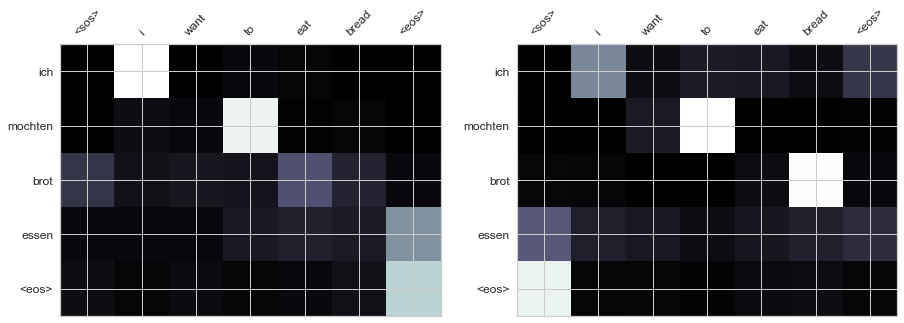

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-1.7351,  0.1618, -0.3740, -0.0206,  1.0327,  2.2861, -0.2796,
           0.2328, -1.3153,  0.0568, -0.0163, -0.4965, -1.0999, -1.0323,
           0.7719, -1.3633,  0.7204,  2.0212, -0.7264,  0.1892, -0.3023,
           0.0793,  0.2864, -0.0564,  0.5614,  0.1300, -0.5955,  0.8895,
           0.3214,  0.5536,  0.5574, -0.4192, -0.2304, -0.0123, -0.2104,
           0.0398,  0.7016,  0.6025,  0.5994,  0.1935, -0.4751,  1.4900,
          -0.2949, -0.8869,  0.1395,  1.5797,  2.0397, -1.4392, -0.4803,
          -0.7776, -0.3768,  1.0322,  1.0407, -0.9410, -1.7982,  1.9598,
          -1.0583, -1.6330,  0.3366, -0.5349, -1.3855,  0.0245, -2.3689,
           2.1333]]])
src = ['i', 'want', 'to', 'eat', 'apple']
predicted trg = ['ich', 'mochten', 'apfel', 'essen', '<eos>']


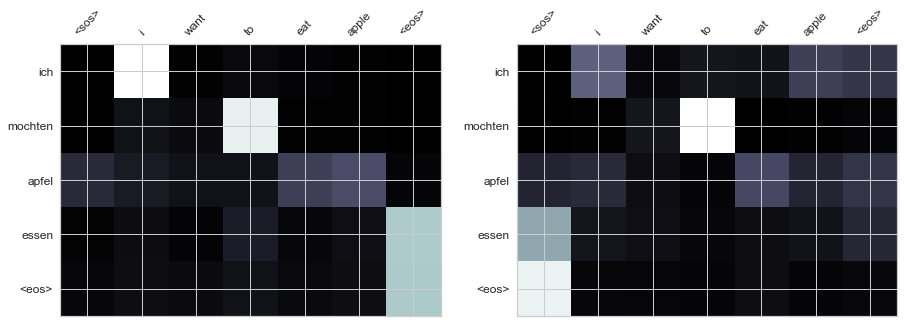

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-1.8017,  0.2611, -0.2967,  0.0033,  0.9981,  2.3713, -0.3086,
           0.1796, -1.2938,  0.0573, -0.0737, -0.5142, -1.0751, -0.9457,
           1.0076, -1.3452,  0.7007,  2.0046, -0.7745,  0.2658, -0.4368,
           0.1287,  0.5477,  0.0628,  0.4703,  0.2151, -0.2870,  0.8835,
           0.2915,  0.7129,  0.5569, -0.4654, -0.2865, -0.1682, -0.4716,
          -0.1584,  0.5534,  0.7152,  0.6311,  0.2726, -0.5361,  1.4951,
          -0.3874, -0.9091, -0.1669,  1.5431,  2.0933, -1.4367, -0.4403,
          -0.8956, -0.5269,  0.7874,  1.0031, -0.6711, -1.8181,  1.7943,
          -0.9300, -1.7175,  0.4383, -0.5441, -1.2372,  0.0396, -2.3203,
           2.1871]]])
src = ['i', 'want', 'to', 'drink', 'water']
predicted trg = ['ich', 'mochten', 'wasser', 'trinken', '<eos>']


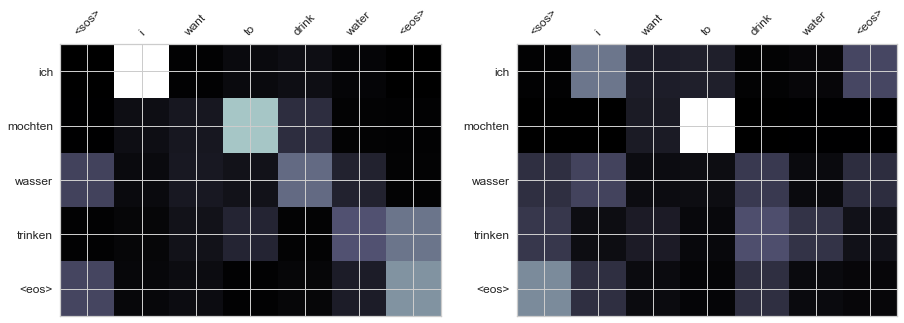

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-1.2555, -0.1767, -0.3128, -0.6967,  0.7889,  2.4494, -0.5505,
           0.2402, -1.1726,  0.5501,  0.6836, -0.2690, -0.8987, -1.7901,
           0.6975, -0.3601,  0.6892,  1.5048, -0.4395, -0.2782,  0.2968,
          -0.4201, -0.1267, -0.6312,  0.9145, -0.3907, -0.4252,  0.0492,
          -0.1495,  0.4029,  0.5298, -0.2036,  0.0897, -0.1012, -0.2481,
           0.4661,  0.8414, -0.2521,  0.7754, -0.5577, -0.2477,  1.3487,
          -0.0739, -1.1866,  0.8717,  1.8963,  2.4227, -1.2107, -0.1035,
          -0.6989, -0.3585,  0.6333,  1.2043, -0.7826, -1.1767,  2.0154,
          -1.0901, -1.4531,  0.3111, -0.8848, -1.8319,  0.3316, -2.3451,
           2.2061]]])
src = ['i', 'want', 'to', 'drink', 'beer']
predicted trg = ['ich', 'mochten', 'bier', 'trinken', '<eos>']


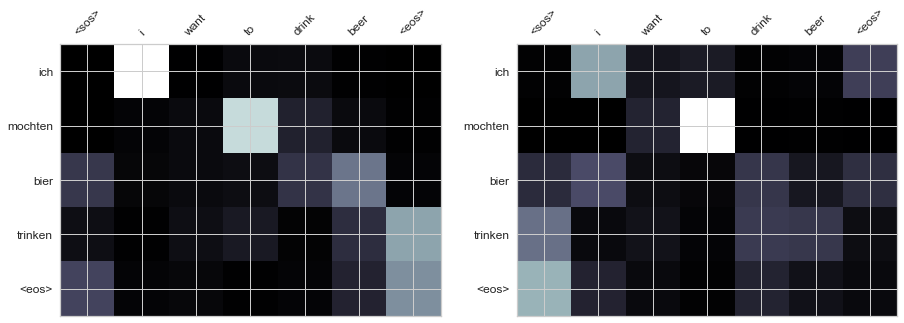

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-1.4393e+00, -7.8354e-02, -3.3327e-01, -5.3460e-01,  8.5102e-01,
           2.2960e+00, -4.5016e-01,  4.3410e-01, -1.2985e+00,  2.0030e-01,
           7.4137e-01, -5.8544e-01, -8.9914e-01, -1.2904e+00,  8.0904e-01,
          -6.5790e-01,  1.0745e+00,  1.9475e+00, -4.8212e-01, -3.5777e-01,
           7.9943e-02, -2.3565e-01, -2.0405e-01, -6.8627e-01,  9.8114e-01,
          -1.2892e-01, -5.6943e-01,  4.8841e-01, -1.0797e-01,  3.1466e-01,
           3.8765e-01, -2.6429e-01,  5.3330e-02, -1.8544e-03, -4.8728e-02,
           4.7315e-01,  1.0301e+00, -8.9778e-03,  6.6789e-01, -2.7168e-01,
          -3.9081e-01,  1.2473e+00, -1.0700e-01, -9.8187e-01,  7.0823e-01,
           1.8982e+00,  2.1322e+00, -1.0844e+00, -4.1441e-01, -5.9106e-01,
          -4.2744e-01,  8.6509e-01,  1.0117e+00, -1.1334e+00, -1.3198e+00,
           1.9680e+00, -1.2130e+00, -1.4849e+00,  3.1321e

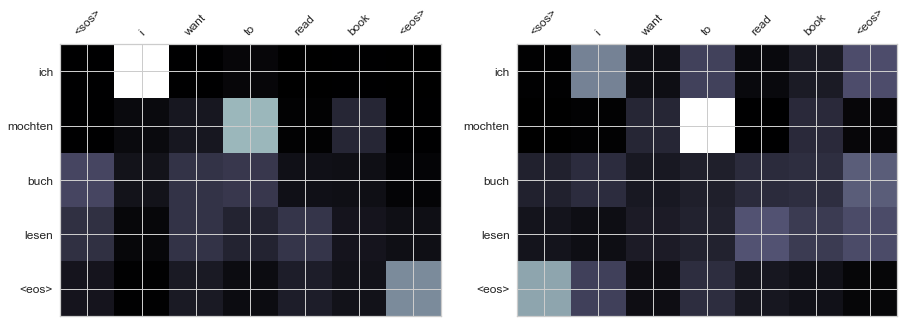

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-1.1651,  0.0221, -0.3873, -0.1546,  0.4245,  2.2978, -0.7751,
           0.1107, -1.0806,  0.4122,  0.1069, -0.3558, -0.8280, -1.5747,
           0.9176, -0.9884,  1.0839,  1.6258, -0.9328, -0.2364,  0.0599,
          -0.1125,  0.0133, -0.0950,  0.7237, -0.1864, -0.4649,  0.3563,
           0.1715,  0.4262,  0.7281, -0.1862,  0.1080,  0.0198, -0.2683,
           0.1423,  0.4902,  0.2354,  0.8655, -0.5280, -0.4875,  1.0731,
          -0.0056, -1.2002,  0.9420,  1.5641,  2.1847, -1.3892, -0.2371,
          -0.5061, -0.2089,  1.2225,  1.4283, -1.1625, -1.6043,  1.8287,
          -0.5561, -1.8884,  0.4499, -0.8083, -1.9648,  0.2017, -2.2041,
           2.3424]]])
src = ['i', 'want', 'to', 'read', 'newspaper']
predicted trg = ['ich', 'mochten', 'zeitung', 'lesen', '<eos>']


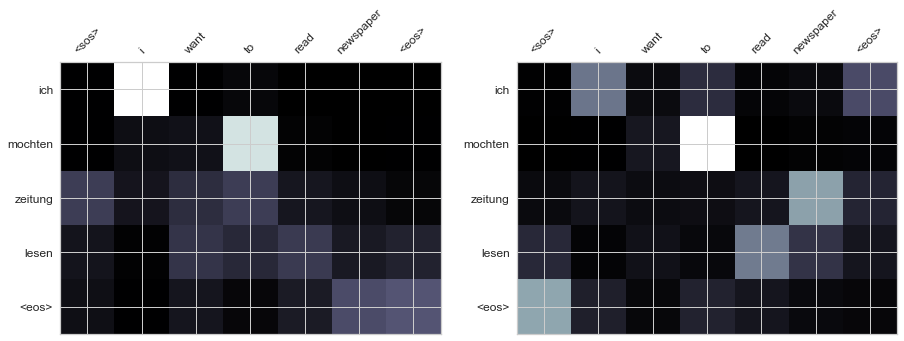

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-1.0915e+00,  9.6793e-02, -6.9662e-03, -9.5078e-02,  3.5858e-01,
           2.3532e+00, -8.6234e-01,  1.6332e-01, -1.3326e+00,  2.8202e-01,
           2.0531e-01, -4.2273e-01, -8.1339e-01, -1.4742e+00,  8.1224e-01,
          -1.3003e+00,  1.1771e+00,  1.5905e+00, -9.2515e-01, -1.5662e-01,
          -6.8562e-02,  2.5634e-01, -2.0009e-03, -2.0924e-02,  5.4368e-01,
          -2.9453e-02, -4.6258e-01,  3.9134e-01,  3.3293e-01,  3.7518e-01,
           7.8803e-01, -2.8390e-01,  1.9696e-01,  2.2666e-01, -1.9398e-01,
           7.2410e-02,  3.9752e-01,  1.9807e-01,  4.9600e-01, -2.3617e-01,
          -6.6564e-01,  1.1631e+00, -4.0989e-02, -1.0061e+00,  6.5785e-01,
           1.4950e+00,  2.1544e+00, -1.3852e+00, -2.7772e-01, -5.3428e-01,
          -1.3954e-01,  1.2118e+00,  1.5815e+00, -1.1031e+00, -1.9272e+00,
           1.8925e+00, -6.7149e-01, -1.8552e+00,  3.7320e

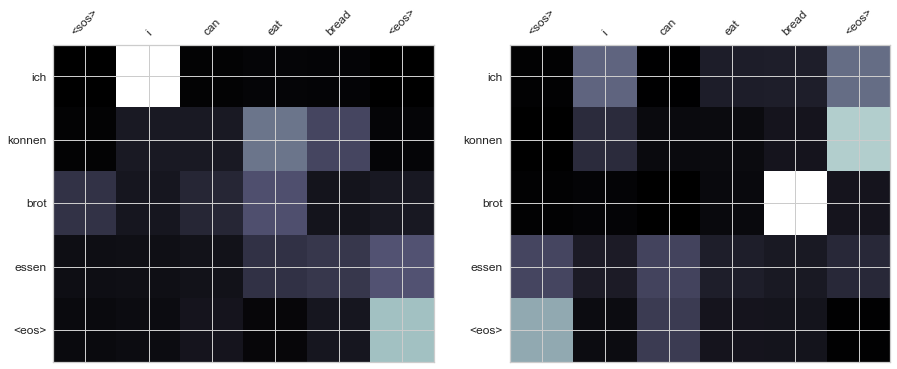

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-2.2036,  0.3158, -1.2559, -0.4176,  1.5641,  1.6282,  0.3032,
           0.4607, -0.5817,  0.1523, -0.7189, -0.7818, -0.8421, -1.7219,
           0.8334, -1.3485,  0.5479,  1.8959, -0.2699,  0.6982, -0.5297,
          -0.6569,  0.4100,  0.0972,  0.7895, -0.3111, -0.8404,  1.4349,
           0.2640,  0.7286,  0.6928, -0.0609, -0.1210, -0.7937, -0.5933,
          -0.2486,  0.1691,  0.4348,  0.2468,  0.2748, -0.4255,  1.7598,
          -0.4131, -0.8081,  0.6836,  1.6644,  2.3954, -1.2789, -0.2180,
          -0.8249, -0.3564,  1.0686,  0.2681, -0.7342, -1.5337,  1.2865,
          -0.3170, -1.1397,  0.6116, -0.1263, -1.6215,  0.7202, -1.9995,
           1.7733]]])
src = ['i', 'can', 'eat', 'apple']
predicted trg = ['ich', 'konnen', 'apfel', 'essen', '<eos>']


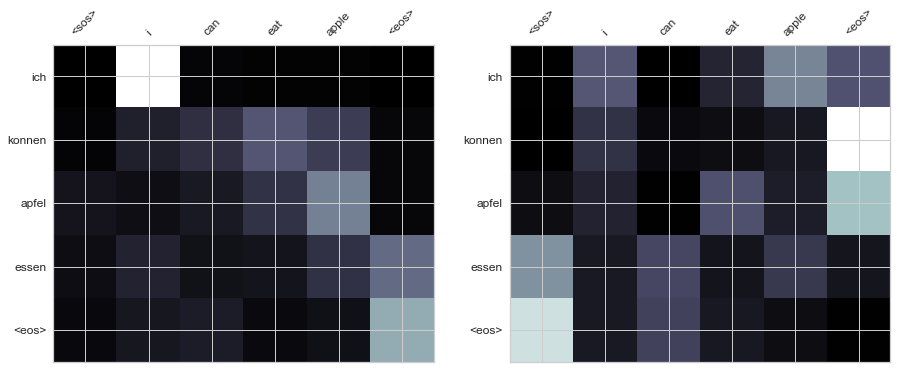

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-2.1456,  0.3651, -1.0831, -0.4128,  1.5202,  1.9401,  0.1774,
           0.3350, -0.6851,  0.1457, -0.6312, -0.8487, -0.7933, -1.5675,
           1.0460, -1.1919,  0.4566,  1.8388, -0.5084,  0.7221, -0.3347,
          -0.6126,  0.7347,  0.3247,  0.6480, -0.2181, -0.7397,  1.2854,
           0.0535,  0.7286,  0.7636, -0.1191, -0.1510, -0.8449, -0.8976,
          -0.4689,  0.0614,  0.7150,  0.5500,  0.3988, -0.3978,  1.6192,
          -0.4647, -0.8919,  0.2631,  1.5261,  2.4268, -1.2593, -0.2543,
          -0.9964, -0.4749,  0.8878,  0.3588, -0.5032, -1.5154,  1.3939,
          -0.2291, -1.4550,  0.7933, -0.0296, -1.3634,  0.5654, -2.1877,
           1.7002]]])
src = ['i', 'can', 'drink', 'water']
predicted trg = ['ich', 'konnen', 'wasser', 'trinken', '<eos>']


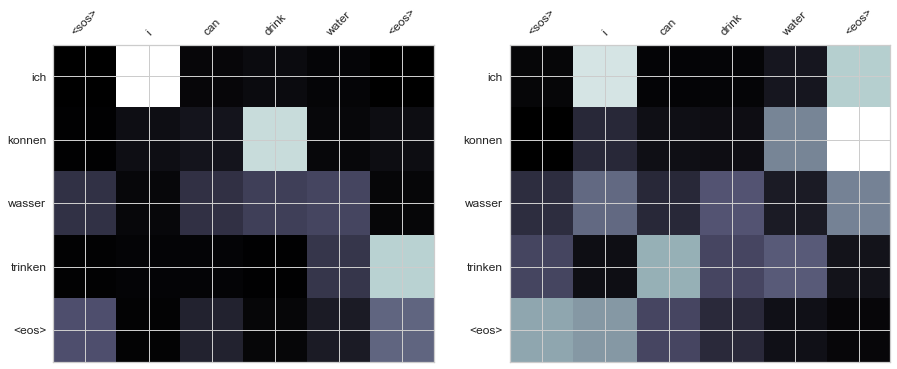

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-1.4940e+00, -1.5930e-01, -1.0580e+00, -1.0116e+00,  9.1183e-01,
           2.2354e+00, -1.5837e-01,  3.4703e-01, -6.4350e-01,  6.9168e-01,
           3.9615e-01, -5.1642e-01, -6.9277e-01, -2.2253e+00,  1.0529e+00,
          -1.7562e-01,  6.2090e-01,  1.2872e+00,  8.6541e-02, -9.4496e-02,
           2.3152e-01, -7.8664e-01, -1.9133e-01, -4.3388e-01,  9.4037e-01,
          -6.7833e-01, -6.3566e-01,  2.8480e-01, -5.0138e-01,  5.0984e-01,
           4.7199e-01,  9.1885e-02,  2.4657e-01, -3.8347e-01, -5.5224e-01,
           4.2976e-01,  5.4698e-01, -4.6524e-01,  8.0617e-01, -4.1947e-01,
           3.2164e-02,  1.2576e+00, -8.1290e-02, -1.3973e+00,  1.0309e+00,
           2.2332e+00,  2.6824e+00, -1.2395e+00, -4.3061e-04, -8.2146e-01,
          -2.3078e-01,  3.4688e-01,  7.8351e-01, -6.1124e-01, -8.7725e-01,
           1.7502e+00, -7.8963e-01, -1.2664e+00,  5.3656e

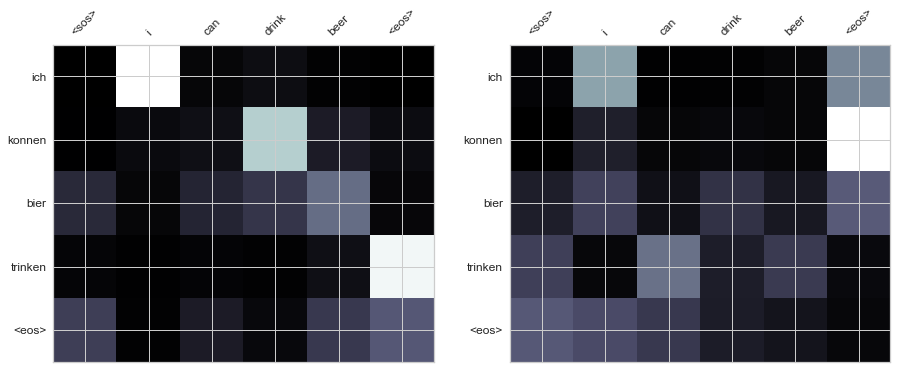

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-1.8826, -0.1021, -1.3466, -0.8823,  0.8537,  1.9782, -0.1491,
           0.5957, -0.8040,  0.5148,  0.3581, -0.8917, -0.6947, -1.9329,
           1.1550, -0.2598,  0.7998,  1.6755,  0.1104, -0.0903,  0.1297,
          -0.8448, -0.2988, -0.4837,  1.0550, -0.4797, -1.0824,  0.7229,
          -0.2988,  0.3978,  0.3516,  0.2380,  0.2470, -0.4743, -0.2752,
           0.3535,  0.7473, -0.1802,  0.8695, -0.3665, -0.1155,  1.1695,
          -0.0365, -1.2813,  1.0191,  2.2096,  2.5821, -0.7787, -0.1849,
          -0.7464, -0.2292,  0.4581,  0.4931, -0.9550, -0.8350,  1.5492,
          -0.7505, -1.0200,  0.5210, -0.4772, -2.1271,  0.6722, -2.1390,
           1.7449]]])
src = ['i', 'can', 'read', 'book']
predicted trg = ['ich', 'konnen', 'buch', 'lesen', '<eos>']


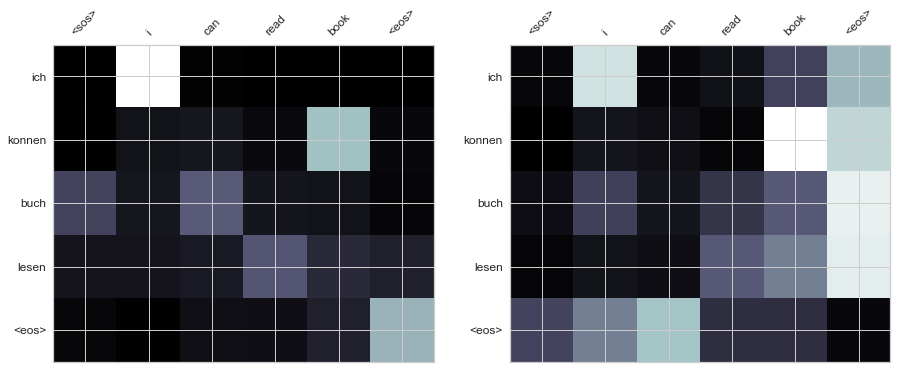

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-1.6181,  0.0738, -1.3756, -0.6931,  0.5647,  2.1109, -0.2417,
           0.1541, -0.7306,  0.5670, -0.1448, -0.6642, -0.6042, -2.3205,
           1.1240, -0.4981,  0.8233,  1.5251, -0.3632,  0.2374,  0.2460,
          -0.8898,  0.0547,  0.3140,  0.7108, -0.4933, -1.1802,  0.5095,
          -0.4113,  0.3731,  0.6193,  0.2694,  0.4461, -0.3963, -0.3645,
           0.2499,  0.3351, -0.0449,  1.0867, -0.3069, -0.2174,  1.0950,
          -0.1133, -1.3022,  1.0081,  1.9088,  2.4034, -1.1319, -0.0800,
          -0.7118,  0.1333,  0.9760,  0.9282, -0.8480, -0.9384,  1.4168,
          -0.2336, -1.5888,  0.7671, -0.5156, -2.2300,  0.8259, -2.1697,
           1.6110]]])
src = ['i', 'can', 'read', 'newspaper']
predicted trg = ['ich', 'konnen', 'zeitung', 'lesen', '<eos>']


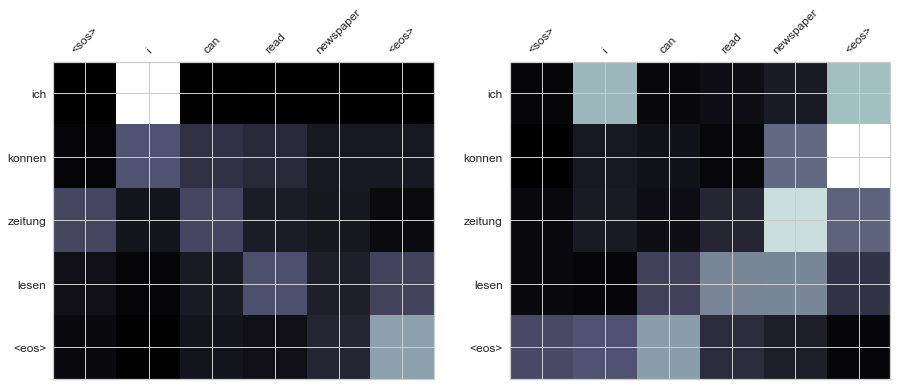

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-1.5493,  0.1125, -1.0487, -0.7417,  0.6217,  2.0610, -0.1950,
           0.3665, -0.9629,  0.3925, -0.1169, -0.7896, -0.6054, -2.3183,
           1.0516, -0.8280,  0.9416,  1.6249, -0.3791,  0.3730,  0.1544,
          -0.7484,  0.0766,  0.4210,  0.6122, -0.2611, -1.2581,  0.5797,
          -0.2293,  0.4127,  0.5584,  0.3321,  0.5770, -0.4395, -0.2765,
           0.1189,  0.1427, -0.1042,  0.7509,  0.0205, -0.2799,  1.2296,
          -0.2310, -1.2462,  0.8703,  1.7787,  2.5345, -1.0739, -0.2313,
          -0.7073,  0.1258,  1.1364,  1.0461, -0.8271, -1.2829,  1.3563,
          -0.1591, -1.6436,  0.7129, -0.4675, -2.1107,  0.6023, -2.2233,
           1.6800]]])
src = ['we', 'want', 'to', 'eat', 'bread']
predicted trg = ['wir', 'mochten', 'brot', 'essen', '<eos>']


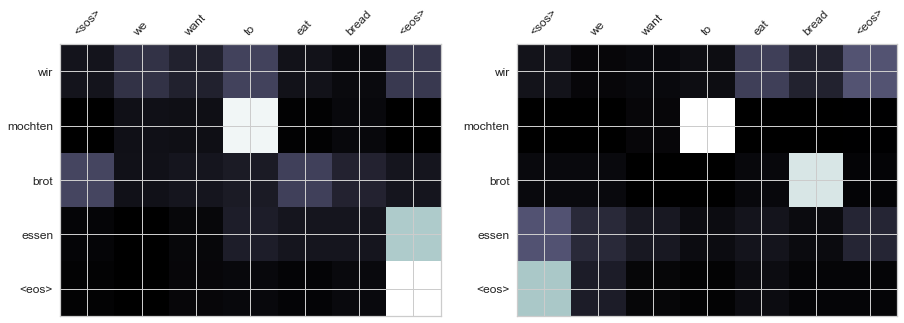

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-1.2708,  0.3755, -0.1442, -0.7491,  0.9974,  2.1600, -0.3645,
           0.3054, -1.6588, -0.5482,  0.2102, -0.2257, -1.0522, -1.2532,
           0.5423, -1.7919,  1.0234,  1.6629, -1.3029,  0.2927, -0.2699,
           0.0435,  0.1871,  0.7128,  0.3651,  0.1868, -0.6788,  0.8081,
          -0.1153,  0.5708,  0.2078, -0.1559, -0.0295, -0.2620, -0.2809,
           0.1026,  0.4893,  0.1280,  0.6138,  0.5686, -0.6734,  1.5511,
          -0.3869, -1.0898,  0.0463,  1.4609,  2.0184, -1.0990, -0.3993,
          -0.7370, -0.1108,  0.7482,  1.4289, -0.8267, -1.5997,  2.1433,
          -0.9065, -1.4872,  0.9177, -0.6118, -0.7378,  0.0241, -2.3250,
           2.2794]]])
src = ['we', 'want', 'to', 'eat', 'apple']
predicted trg = ['wir', 'mochten', 'apfel', 'essen', '<eos>']


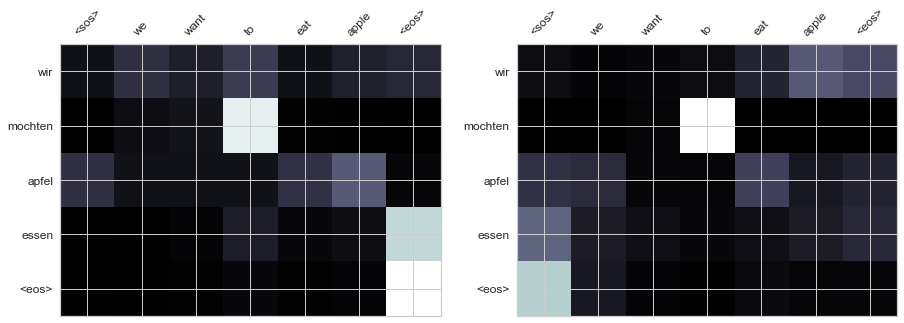

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-1.3944,  0.4491, -0.1688, -0.7077,  0.9164,  2.2670, -0.3990,
           0.2358, -1.6414, -0.4647,  0.0174, -0.2985, -1.0076, -1.2270,
           0.6598, -1.8078,  0.9226,  1.6960, -1.2539,  0.3553, -0.2720,
           0.1042,  0.3693,  0.7590,  0.2756,  0.2755, -0.6512,  0.8062,
          -0.0179,  0.7085,  0.3513, -0.0920, -0.0133, -0.3461, -0.4422,
           0.0365,  0.3461,  0.2974,  0.6386,  0.6463, -0.6972,  1.5139,
          -0.4439, -1.1511, -0.1109,  1.4601,  2.0449, -1.0995, -0.4087,
          -0.8374, -0.1957,  0.6296,  1.3503, -0.7719, -1.6132,  1.9952,
          -0.7777, -1.5385,  0.9730, -0.5427, -0.8233,  0.1499, -2.2540,
           2.2483]]])
src = ['we', 'want', 'to', 'drink', 'water']
predicted trg = ['wir', 'mochten', 'wasser', 'trinken', '<eos>']


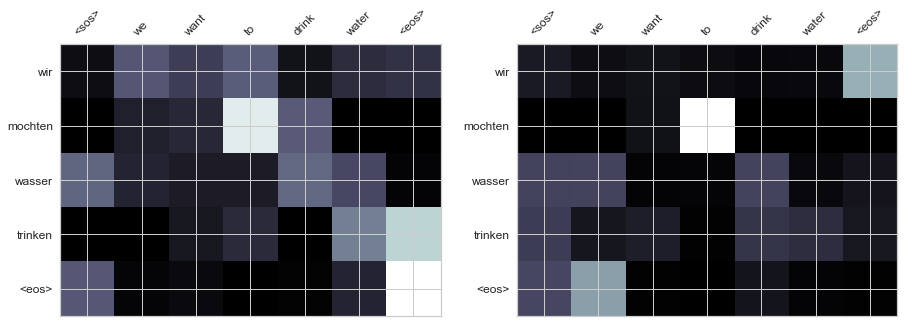

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-0.9610,  0.1613, -0.1625, -1.2414,  0.8785,  2.1478, -0.4000,
           0.6600, -1.6157, -0.4534,  0.8738, -0.1425, -0.9410, -1.6259,
           0.4628, -0.9592,  1.3966,  1.3379, -1.2698,  0.0527, -0.1222,
          -0.1366, -0.1617,  0.4260,  0.5701, -0.2196, -0.6542,  0.4483,
          -0.4127,  0.5988,  0.0174, -0.0704,  0.0567, -0.4782, -0.2161,
           0.2479,  0.5710, -0.5350,  0.7363,  0.0474, -0.6493,  1.4432,
          -0.3819, -1.4143,  0.4048,  1.5405,  2.3143, -0.8388, -0.2017,
          -0.4720, -0.1404,  0.3412,  1.5493, -0.7255, -1.2086,  2.1571,
          -0.8610, -1.1417,  0.7525, -0.8706, -0.8254,  0.0094, -2.3268,
           2.7001]]])
src = ['we', 'want', 'to', 'drink', 'beer']
predicted trg = ['wir', 'mochten', 'bier', 'trinken', '<eos>']


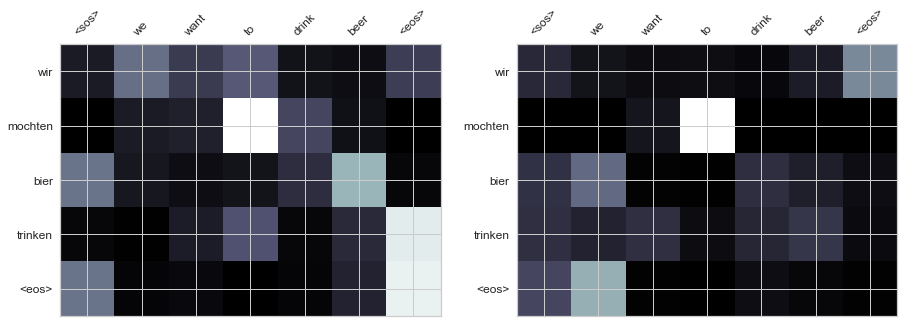

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-1.0165,  0.4878, -0.0045, -1.2868,  0.8624,  1.8859, -0.4240,
           0.7703, -1.7317, -0.7830,  0.9475, -0.1908, -0.8685, -1.3315,
           0.4200, -1.2805,  1.7512,  1.4842, -1.5434,  0.0443, -0.3493,
           0.0647, -0.2037,  0.5402,  0.5951, -0.1063, -0.6514,  0.6778,
          -0.4544,  0.4750, -0.1743, -0.0636, -0.0215, -0.4578, -0.1425,
           0.3961,  0.6538, -0.6783,  0.5324,  0.3768, -0.8311,  1.3493,
          -0.3442, -1.2811,  0.2099,  1.5124,  2.0844, -0.7114, -0.4239,
          -0.2671, -0.0674,  0.4429,  1.4889, -0.7970, -1.2941,  1.9478,
          -0.8199, -0.9858,  0.8221, -0.7046, -0.4676, -0.4599, -2.2920,
           2.7452]]])
src = ['we', 'want', 'to', 'read', 'book']
predicted trg = ['wir', 'mochten', 'buch', 'lesen', '<eos>']


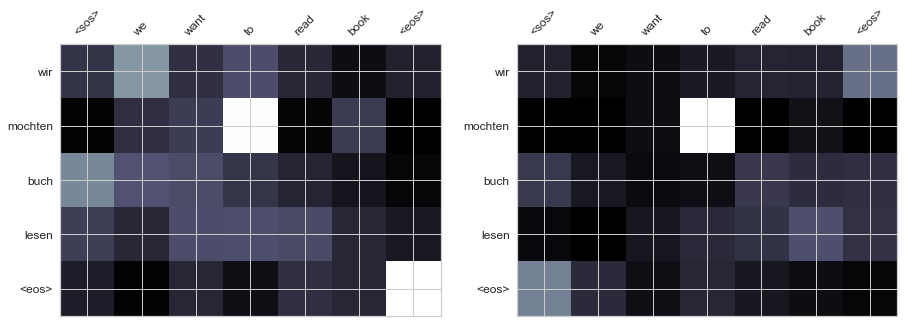

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-0.7249,  0.3082, -0.0573, -0.6692,  0.2951,  2.3105, -0.8651,
           0.3326, -1.5486, -0.3742,  0.3705, -0.1829, -0.8131, -1.5901,
           0.5296, -1.6991,  1.5513,  1.0963, -1.7132,  0.0432, -0.1899,
           0.1140, -0.0751,  0.9754,  0.2776, -0.1516, -0.3815,  0.4109,
          -0.3690,  0.5323,  0.1943,  0.0576,  0.0442, -0.2151, -0.3141,
           0.2344,  0.2238, -0.2032,  0.7055,  0.1905, -0.6736,  1.0941,
          -0.0373, -1.3098,  0.5140,  1.5054,  2.0098, -1.0837, -0.1387,
          -0.4588,  0.0722,  0.7910,  1.9307, -1.0721, -1.6694,  1.9519,
          -0.4048, -1.5296,  1.1264, -0.7539, -0.8961,  0.0604, -2.1251,
           2.4543]]])
src = ['we', 'want', 'to', 'read', 'newspaper']
predicted trg = ['wir', 'mochten', 'zeitung', 'lesen', '<eos>']


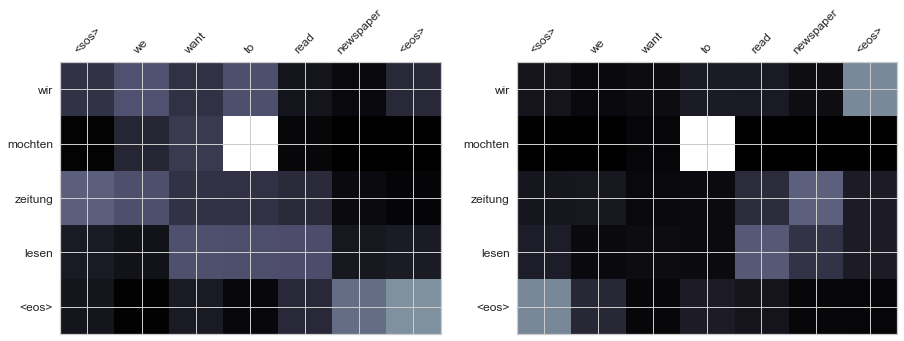

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-0.5766,  0.3795,  0.1720, -0.8571,  0.5580,  2.2756, -0.7535,
           0.2298, -1.5177, -0.4276,  0.2811, -0.0829, -0.9159, -1.5136,
           0.3753, -2.0917,  1.3577,  1.2351, -1.3485,  0.0803, -0.0445,
           0.2827, -0.0826,  0.9267,  0.2730, -0.1790, -0.7913,  0.3920,
          -0.0993,  0.4354,  0.5099,  0.0807,  0.2815, -0.0762, -0.3767,
           0.1477,  0.1519, -0.1456,  0.5127,  0.2530, -0.9299,  1.2626,
          -0.1637, -1.1200,  0.3439,  1.4537,  2.0428, -1.3149, -0.1762,
          -0.5142,  0.1406,  0.7603,  1.8441, -0.9614, -1.7431,  2.0750,
          -0.5470, -1.4342,  0.9135, -0.9014, -1.0513,  0.2710, -1.9231,
           2.3935]]])
src = ['we', 'can', 'eat', 'bread']
predicted trg = ['wir', 'konnen', 'brot', 'essen', '<eos>']


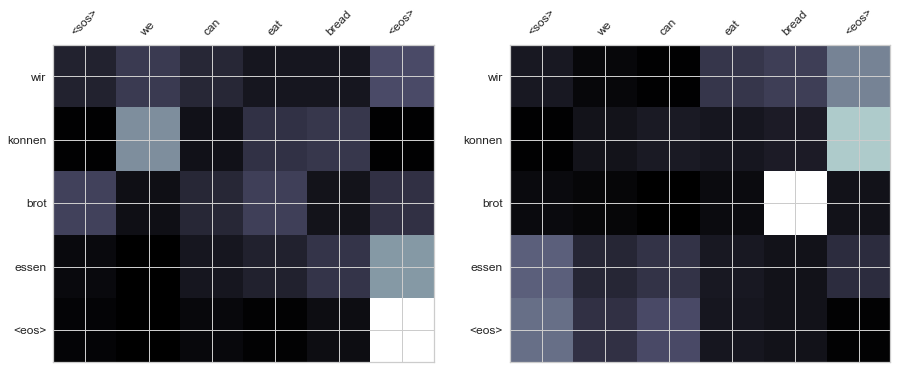

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-1.6484,  0.5072, -0.6435, -1.0962,  1.2411,  1.8856,  0.0793,
           0.5953, -1.3378, -0.6374, -0.2024, -0.4824, -0.7758, -1.6804,
           0.4490, -1.7475,  1.2681,  1.3394, -1.2408,  0.6897, -0.6924,
          -0.4954,  0.3157,  1.0996,  0.4629, -0.1533, -0.4415,  1.2670,
          -0.4326,  0.8451,  0.0580,  0.0717, -0.1735, -0.9212, -0.5106,
          -0.2048,  0.1019,  0.0731,  0.2143,  0.7606, -0.4169,  1.5833,
          -0.4659, -1.0326,  0.3068,  1.6569,  2.2715, -0.8995, -0.0858,
          -0.7367, -0.0341,  0.6717,  1.0036, -0.6012, -1.4487,  1.7396,
          -0.3828, -1.1396,  1.0524, -0.4437, -0.4334,  0.3226, -2.3293,
           2.0920]]])
src = ['we', 'can', 'eat', 'apple']
predicted trg = ['wir', 'konnen', 'apfel', 'essen', '<eos>']


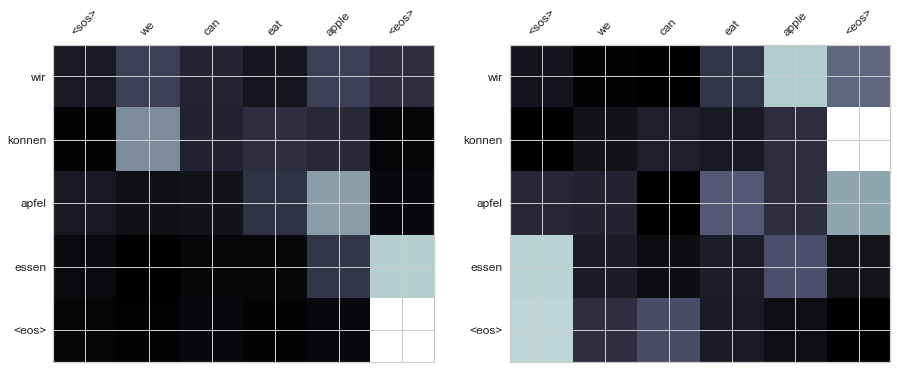

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-1.7435,  0.5399, -0.6595, -1.0296,  1.1856,  1.9937,  0.0362,
           0.4209, -1.3025, -0.5065, -0.3449, -0.5767, -0.6637, -1.5576,
           0.6236, -1.6362,  0.9974,  1.5047, -1.1987,  0.6918, -0.4806,
          -0.4350,  0.5933,  1.1462,  0.4330, -0.0581, -0.4820,  1.2135,
          -0.3943,  0.8967,  0.2011,  0.0700, -0.1244, -0.9491, -0.8039,
          -0.3274, -0.0536,  0.4120,  0.4393,  0.7666, -0.4437,  1.5945,
          -0.4501, -1.1783,  0.0635,  1.4635,  2.3417, -0.8051, -0.1464,
          -0.9390, -0.1924,  0.5689,  0.9372, -0.5562, -1.4558,  1.6227,
          -0.2867, -1.2797,  1.1824, -0.2530, -0.5458,  0.3853, -2.3855,
           1.9748]]])
src = ['we', 'can', 'drink', 'water']
predicted trg = ['wir', 'konnen', 'wasser', 'trinken', '<eos>']


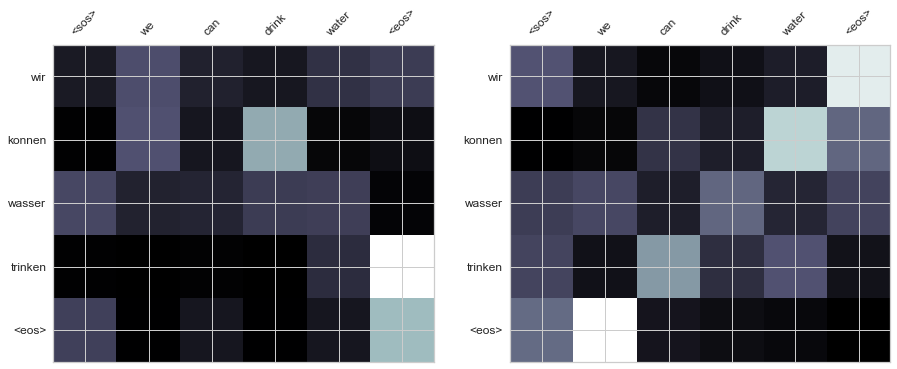

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-1.1002,  0.3218, -0.4536, -1.5529,  1.0014,  2.1873, -0.1004,
           0.8891, -1.3094, -0.6954,  0.7325, -0.3544, -0.7756, -1.6526,
           0.4221, -1.0481,  1.7669,  0.9923, -1.2194,  0.2911, -0.4355,
          -0.3907, -0.1138,  0.8638,  0.5354, -0.5038, -0.3943,  0.7360,
          -0.8274,  0.8032, -0.1287,  0.1296,  0.0148, -0.8383, -0.3975,
           0.0312,  0.2220, -0.5102,  0.3925,  0.4154, -0.3846,  1.2284,
          -0.4595, -1.4691,  0.5016,  1.7123,  2.4673, -0.9991, -0.0860,
          -0.3959, -0.0374,  0.2112,  1.4287, -0.5522, -1.1159,  1.8253,
          -0.4952, -0.8446,  0.8155, -0.8622, -0.5698,  0.0876, -2.3488,
           2.4766]]])
src = ['we', 'can', 'drink', 'beer']
predicted trg = ['wir', 'konnen', 'bier', 'trinken', '<eos>']


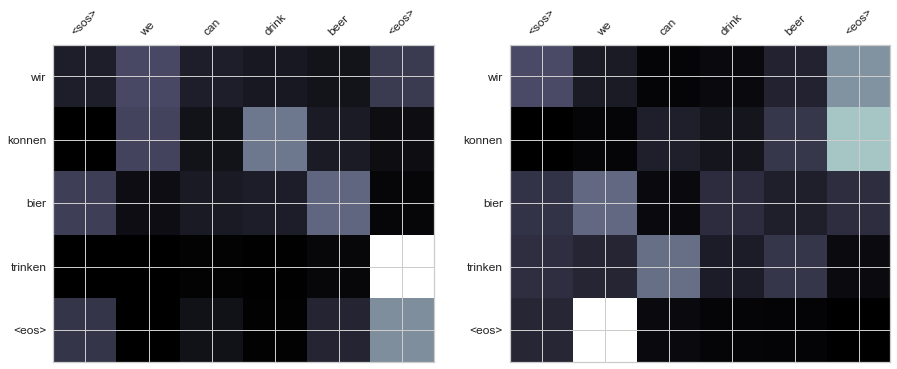

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-1.3322,  0.4572, -0.5091, -1.6939,  0.8735,  2.0133, -0.0721,
           1.0604, -1.4741, -0.9523,  0.6993, -0.4989, -0.6484, -1.5290,
           0.3213, -1.1618,  1.9606,  1.2580, -1.3868,  0.2680, -0.5583,
          -0.3446, -0.2377,  0.9299,  0.4810, -0.2945, -0.5510,  0.9624,
          -0.7460,  0.7004, -0.2942,  0.1815,  0.0070, -0.9803, -0.1832,
           0.1625,  0.3286, -0.5173,  0.3089,  0.6235, -0.5432,  1.2287,
          -0.3511, -1.2993,  0.4531,  1.6830,  2.3046, -0.5703, -0.2370,
          -0.2041,  0.0248,  0.3378,  1.1824, -0.6654, -1.1695,  1.6806,
          -0.5240, -0.5751,  0.8313, -0.6827, -0.3498, -0.1027, -2.4157,
           2.4123]]])
src = ['we', 'can', 'read', 'book']
predicted trg = ['wir', 'konnen', 'buch', 'lesen', '<eos>']


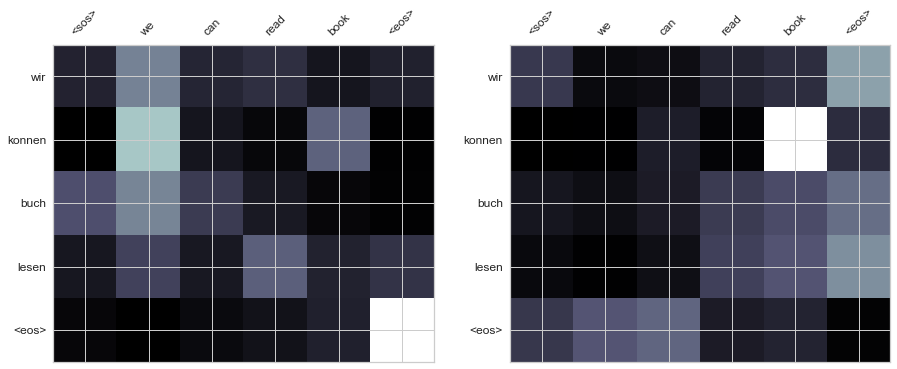

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-1.0062,  0.1636, -0.6088, -1.3062,  0.3905,  2.4705, -0.4130,
           0.6426, -1.4660, -0.5408,  0.4808, -0.3553, -0.5929, -1.8173,
           0.4921, -1.2016,  1.6834,  0.9664, -1.3872,  0.4165, -0.3748,
          -0.5140,  0.0855,  1.2546,  0.3511, -0.2743, -0.4754,  0.6086,
          -0.9920,  0.6019,  0.0426,  0.3427,  0.1916, -0.5302, -0.3533,
           0.0190,  0.0902, -0.2978,  0.6079,  0.2890, -0.3558,  1.0029,
          -0.2068, -1.2997,  0.5645,  1.8170,  2.2589, -0.9298,  0.1011,
          -0.5338,  0.2828,  0.6982,  1.5459, -0.7788, -1.3660,  1.6634,
          -0.2101, -1.3468,  1.1590, -0.7825, -0.7155,  0.2586, -2.4768,
           2.0051]]])
src = ['we', 'can', 'read', 'newspaper']
predicted trg = ['wir', 'konnen', 'zeitung', 'lesen', '<eos>']


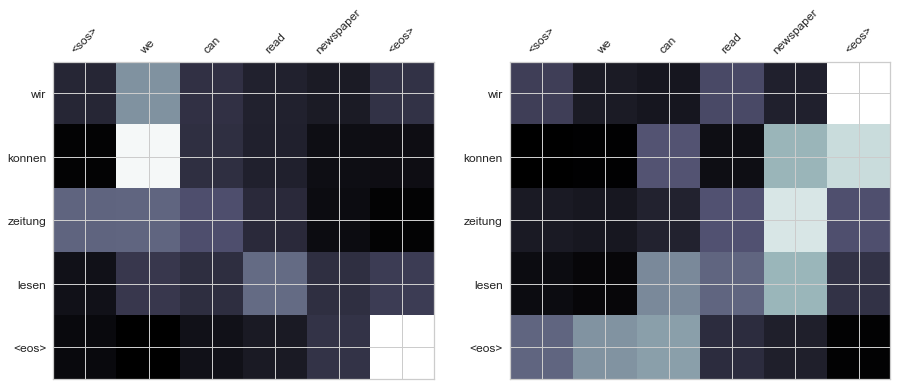

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-0.9262,  0.3960, -0.4180, -1.4009,  0.6062,  2.1746, -0.2034,
           0.5143, -1.3925, -0.5048,  0.0505, -0.5035, -0.6675, -2.2045,
           0.3964, -1.6614,  1.6777,  0.9584, -1.1487,  0.5610, -0.2519,
          -0.4941, -0.0229,  1.5541,  0.0615, -0.2713, -0.7612,  0.5570,
          -0.7750,  0.7411,  0.2845,  0.3917,  0.4841, -0.6692, -0.4239,
           0.0290, -0.1522, -0.3629,  0.5450,  0.5990, -0.4404,  1.2021,
          -0.4981, -1.2009,  0.6146,  1.5968,  2.3028, -1.0099,  0.1150,
          -0.4379,  0.3966,  0.7724,  1.5670, -0.8126, -1.4610,  1.4854,
           0.0231, -1.2555,  1.0710, -0.6924, -0.9734,  0.4182, -2.0424,
           1.9311]]])
src = ['i', 'eat', 'bread']
predicted trg = ['ich', 'essen', 'apfel', '<eos>']


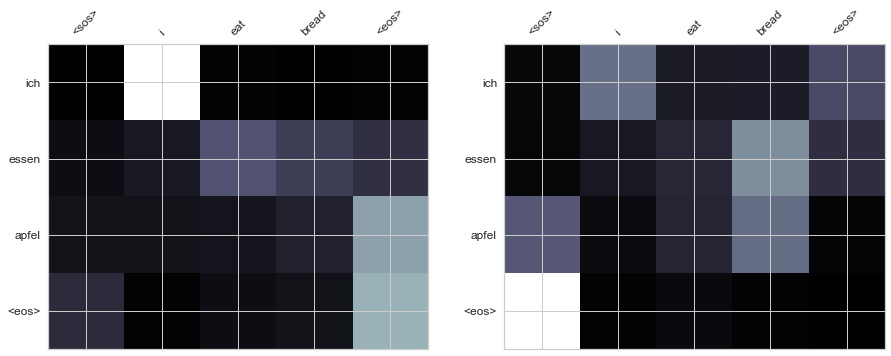

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-2.2283,  0.6052, -1.0877, -0.0069,  1.5969,  1.2031,  0.2160,
           0.2202, -0.5560,  0.4877, -1.0837, -0.9387, -0.7872, -1.8994,
           1.0272, -1.5494,  0.4993,  1.7648, -0.4433,  0.5920, -0.5268,
          -0.5957,  0.2870,  0.3271,  0.8080, -0.0508, -0.2542,  1.3729,
           0.3637,  0.9436,  0.5639, -0.3572, -0.3437, -0.7933, -0.6274,
           0.0224,  0.3759,  0.2494,  0.1818,  0.3562, -0.2316,  1.9853,
          -0.6547, -0.9718,  0.5564,  1.3363,  2.3483, -1.3930, -0.2283,
          -0.6492, -0.5194,  1.0797,  0.3888, -0.4978, -1.6146,  1.1814,
          -0.5036, -1.2848,  0.6935, -0.1493, -1.5331,  0.5756, -1.7552,
           1.9742]]])
src = ['i', 'eat', 'apple']
predicted trg = ['ich', 'essen', 'apfel', '<eos>']


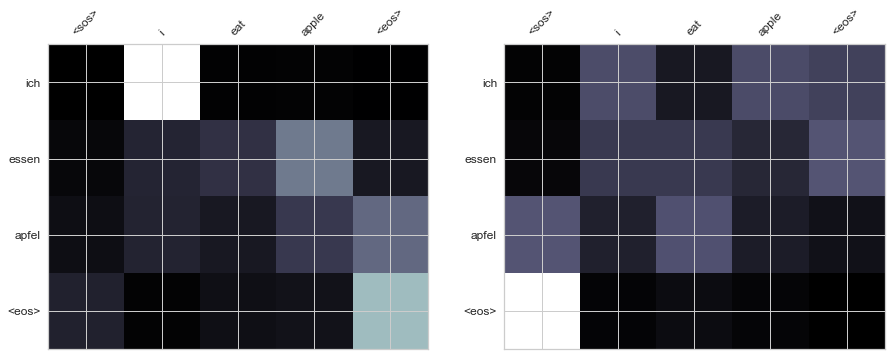

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-2.2193,  0.6343, -0.9034, -0.1362,  1.5597,  1.5312,  0.1514,
           0.2429, -0.7609,  0.3059, -0.8034, -1.0096, -0.6419, -1.6337,
           1.2061, -1.3076,  0.4923,  1.9334, -0.6246,  0.6098, -0.3806,
          -0.5633,  0.6074,  0.3910,  0.7875,  0.0837, -0.2755,  1.2112,
           0.1189,  0.9575,  0.6368, -0.3732, -0.2761, -0.8307, -0.8485,
          -0.3226,  0.3107,  0.4985,  0.3914,  0.4187, -0.3282,  1.8337,
          -0.6637, -1.0370,  0.1395,  1.3128,  2.3255, -1.2866, -0.2587,
          -0.8117, -0.6347,  0.8762,  0.4190, -0.3075, -1.5525,  1.2058,
          -0.3542, -1.5685,  0.8087, -0.0591, -1.3973,  0.3560, -2.0791,
           1.9555]]])
src = ['i', 'drink', 'water']
predicted trg = ['ich', 'trinken', 'bier', '<eos>']


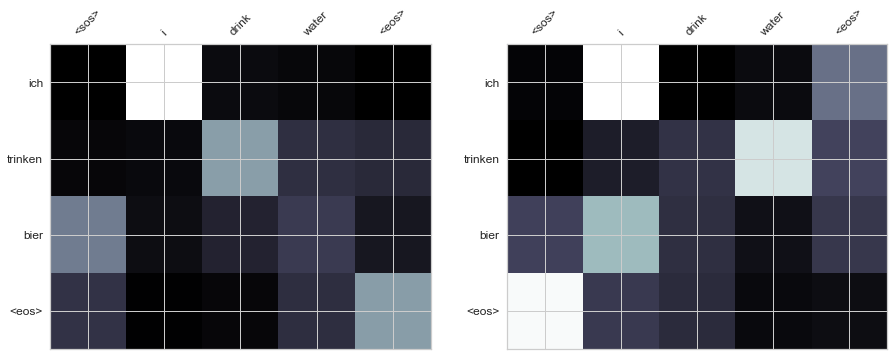

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-1.3563,  0.0422, -0.8679, -0.8678,  1.1392,  1.8855, -0.1270,
           0.2566, -0.4521,  0.8330,  0.3570, -0.4964, -0.6675, -2.3615,
           1.1495, -0.2879,  0.6563,  1.0907,  0.0223, -0.2717,  0.2654,
          -0.6657, -0.3894, -0.3598,  0.9974, -0.7496, -0.0276,  0.0962,
          -0.6706,  0.6491,  0.3554, -0.1952,  0.0642, -0.3700, -0.6933,
           0.7649,  0.6557, -0.8054,  0.8702, -0.3361,  0.1373,  1.4080,
          -0.2944, -1.5716,  1.0804,  1.9512,  2.6475, -1.5069, -0.0048,
          -0.7286, -0.3543,  0.2191,  1.0297, -0.3619, -0.8129,  1.7381,
          -0.9766, -1.4542,  0.6312, -0.7693, -1.8725,  0.6020, -1.7865,
           1.9981]]])
src = ['i', 'drink', 'beer']
predicted trg = ['ich', 'trinken', 'bier', '<eos>']


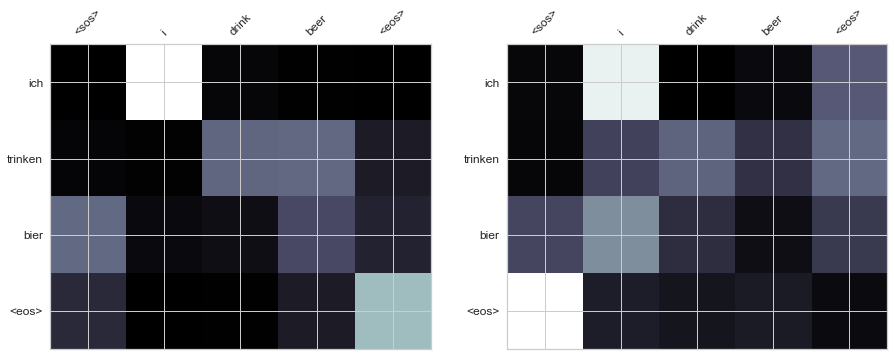

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-1.6892,  0.3214, -1.1203, -0.6529,  1.1742,  1.5235, -0.0738,
           0.3997, -0.6484,  0.7315,  0.1935, -0.9347, -0.6558, -2.1463,
           1.4502, -0.6200,  0.9328,  1.5716, -0.1017, -0.2593,  0.0439,
          -0.6129, -0.4715, -0.3893,  1.1698, -0.3070, -0.3466,  0.5589,
          -0.4356,  0.5708,  0.1810, -0.0949,  0.0413, -0.5568, -0.4589,
           0.8131,  0.9525, -0.5911,  0.8359, -0.0866, -0.1003,  1.4078,
          -0.3017, -1.5215,  0.9194,  1.8329,  2.5878, -1.1135, -0.3713,
          -0.4938, -0.3565,  0.3364,  0.8204, -0.7030, -0.8413,  1.4620,
          -0.9536, -1.3398,  0.6948, -0.6043, -2.0001,  0.2305, -1.8845,
           2.1564]]])
src = ['i', 'read', 'book']
predicted trg = ['ich', 'lesen', '<eos>']


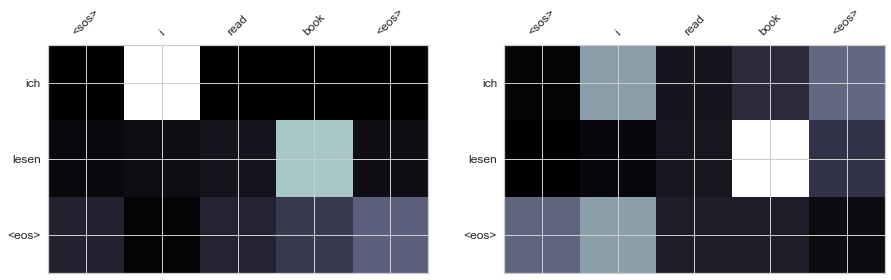

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-1.3883,  0.2873, -0.9255, -0.0515,  0.4380,  1.7947, -0.6253,
          -0.1469, -0.4674,  0.7399, -0.4869, -0.6750, -0.4386, -2.6014,
           1.3044, -0.8187,  1.3671,  1.1180, -0.7115,  0.1020,  0.2449,
          -0.4632, -0.1407,  0.6695,  0.3931, -0.4153, -0.4319,  0.2412,
          -0.3167,  0.6467,  0.6167, -0.0223,  0.3938, -0.3077, -0.4427,
           0.4011,  0.1334, -0.2060,  0.9641, -0.2467, -0.0654,  1.1551,
          -0.3544, -1.4183,  1.0784,  1.3896,  2.2502, -1.5674, -0.1008,
          -0.2899,  0.0140,  1.2035,  1.5147, -0.8611, -1.2879,  1.2170,
          -0.1171, -1.9604,  1.0001, -0.7481, -2.3328,  0.4986, -1.7120,
           1.9908]]])
src = ['i', 'read', 'newspaper']
predicted trg = ['ich', 'lesen', 'zeitung', '<eos>']


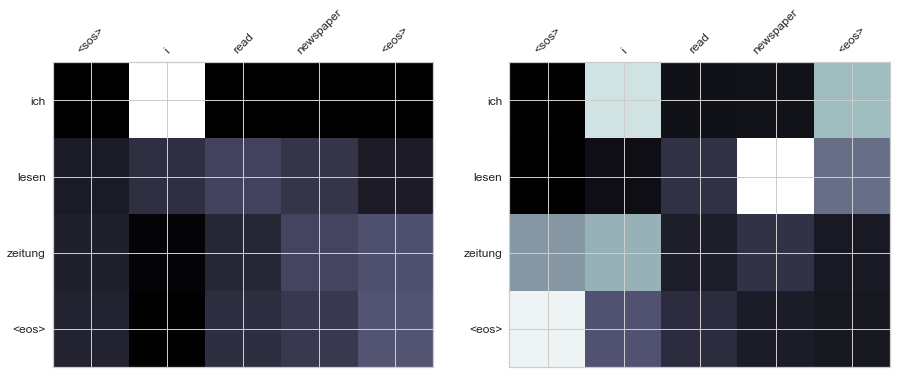

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-1.3310,  0.3143, -0.5670, -0.0079,  0.4881,  1.6575, -0.5386,
           0.0704, -0.8225,  0.4714, -0.4300, -0.8002, -0.5819, -2.5604,
           1.2567, -1.3654,  1.3762,  1.1168, -0.8291,  0.2423, -0.0643,
          -0.1705, -0.0619,  0.7693,  0.1967, -0.1704, -0.4825,  0.3635,
           0.1540,  0.6834,  0.6824, -0.0164,  0.4630, -0.1279, -0.4207,
           0.2560, -0.0357, -0.1932,  0.6555, -0.0621, -0.2576,  1.3966,
          -0.4933, -1.2610,  0.8514,  1.2433,  2.4091, -1.4521, -0.1000,
          -0.1553,  0.0834,  1.1929,  1.6449, -0.8260, -1.7430,  1.2176,
          -0.1580, -1.8651,  0.7478, -0.6603, -2.2274,  0.3502, -1.6665,
           2.1667]]])
src = ['we', 'eat', 'bread']
predicted trg = ['wir', 'essen', 'apfel', '<eos>']


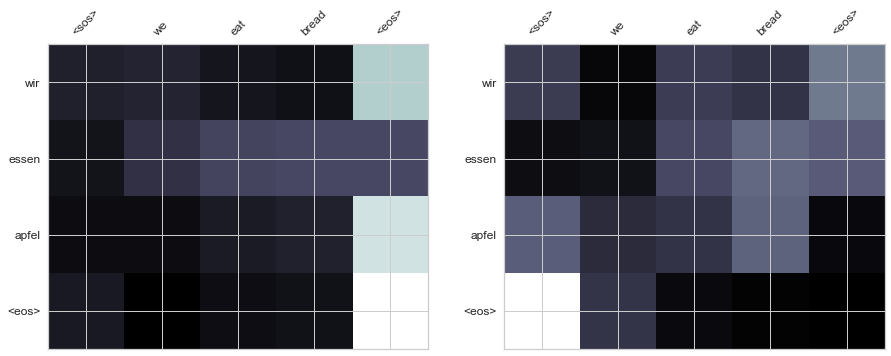

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-1.7160,  0.6839, -0.5133, -0.6894,  1.2650,  1.6201, -0.0398,
           0.3235, -1.2411, -0.4238, -0.5122, -0.6255, -0.6987, -1.8270,
           0.6128, -1.9661,  1.0564,  1.2961, -1.3181,  0.6329, -0.6641,
          -0.4068,  0.3026,  1.3534,  0.3841,  0.0839, -0.0686,  1.1745,
          -0.3384,  1.0658,  0.0299, -0.1080, -0.2551, -0.8864, -0.5767,
           0.0166,  0.2741,  0.0467,  0.2193,  0.8524, -0.3110,  1.7588,
          -0.6589, -1.0755,  0.1084,  1.4065,  2.2417, -1.1178, -0.2899,
          -0.6597, -0.1087,  0.7052,  1.1540, -0.3673, -1.5123,  1.6168,
          -0.5218, -1.3229,  1.2042, -0.3313, -0.5636,  0.2443, -2.0936,
           2.1168]]])
src = ['we', 'eat', 'apple']
predicted trg = ['wir', 'essen', 'apfel', '<eos>']


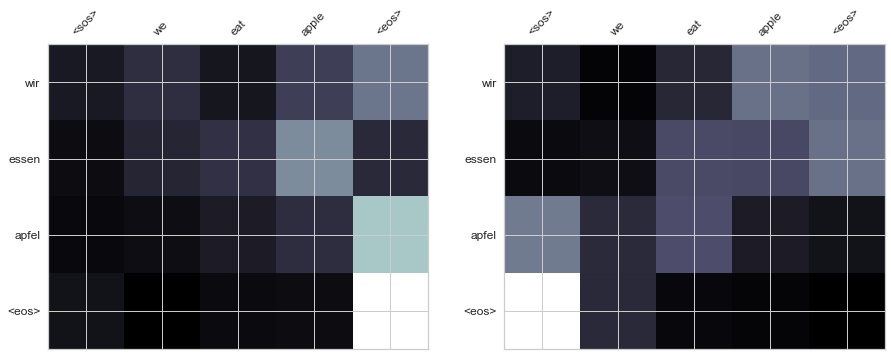

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-1.9206,  0.7174, -0.6296, -0.6984,  1.2312,  1.7303, -0.0038,
           0.2943, -1.2200, -0.3046, -0.6290, -0.7564, -0.5861, -1.6422,
           0.7732, -1.7469,  0.9116,  1.5835, -1.1929,  0.6606, -0.5230,
          -0.3832,  0.4536,  1.2303,  0.4502,  0.2378, -0.2841,  1.1667,
          -0.2385,  1.0763,  0.2590, -0.0058, -0.1274, -0.8938, -0.7595,
          -0.1759,  0.1422,  0.3338,  0.3352,  0.8168, -0.4025,  1.7949,
          -0.6869, -1.2357, -0.0265,  1.3360,  2.2348, -1.0170, -0.2630,
          -0.8035, -0.2490,  0.6393,  0.9399, -0.4114, -1.4819,  1.4186,
          -0.3720, -1.3911,  1.2213, -0.1470, -0.8142,  0.3291, -2.2291,
           1.9818]]])
src = ['we', 'drink', 'water']
predicted trg = ['wir', 'trinken', 'bier', '<eos>']


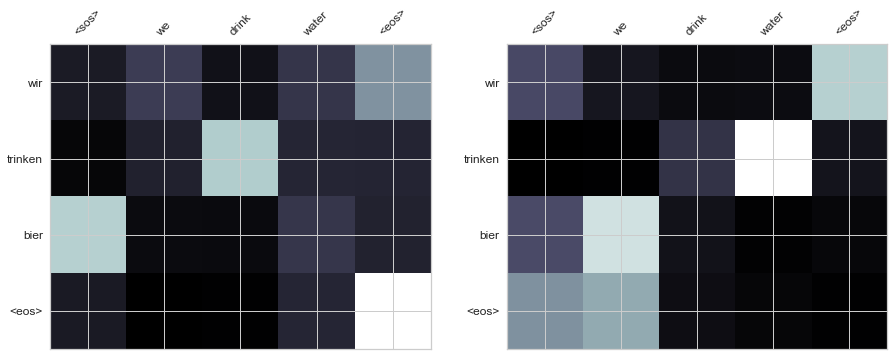

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-1.1483,  0.4610, -0.3890, -1.3613,  1.2036,  1.9240, -0.1139,
           0.7863, -1.2242, -0.5376,  0.6498, -0.3335, -0.7967, -1.8895,
           0.4162, -1.1006,  1.7219,  0.9264, -1.1573,  0.2508, -0.4497,
          -0.3315, -0.1035,  0.9860,  0.6157, -0.5163, -0.1599,  0.7111,
          -0.7995,  0.9364, -0.2729,  0.0451, -0.0962, -0.8918, -0.3937,
           0.2016,  0.3648, -0.7840,  0.3961,  0.4489, -0.3592,  1.4004,
          -0.7241, -1.4660,  0.3985,  1.5299,  2.4945, -1.0878, -0.1903,
          -0.3420, -0.0834,  0.1393,  1.5064, -0.4712, -1.0557,  1.7288,
          -0.6087, -0.8858,  0.8159, -0.7843, -0.6225, -0.0191, -2.1256,
           2.6937]]])
src = ['we', 'drink', 'beer']
predicted trg = ['wir', 'trinken', 'bier', '<eos>']


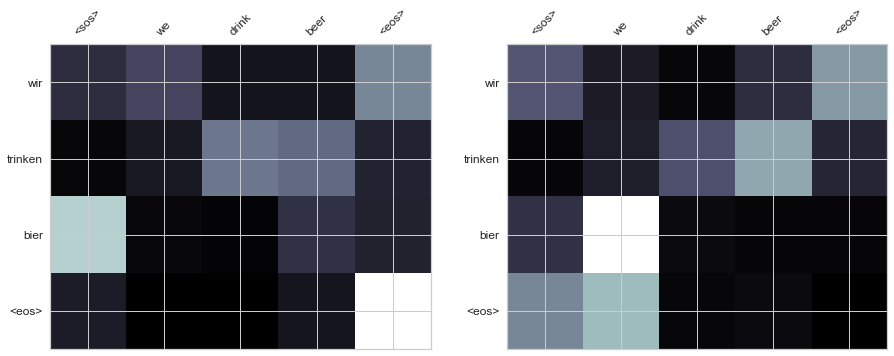

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-1.2769,  0.7480, -0.3103, -1.4688,  1.0633,  1.6964, -0.1605,
           0.9613, -1.4167, -0.8423,  0.6252, -0.4441, -0.7190, -1.6858,
           0.3078, -1.2791,  2.0213,  1.0885, -1.4904,  0.2453, -0.5958,
          -0.2212, -0.1915,  1.0538,  0.6322, -0.3166, -0.2517,  0.8536,
          -0.7106,  0.8569, -0.4732,  0.0294, -0.1991, -0.9615, -0.2492,
           0.3201,  0.5459, -0.8575,  0.2683,  0.5622, -0.5772,  1.2815,
          -0.5898, -1.3703,  0.2546,  1.4677,  2.3523, -0.6810, -0.4000,
          -0.0392,  0.0545,  0.2721,  1.3948, -0.4873, -1.0658,  1.5451,
          -0.5738, -0.5928,  0.8362, -0.6337, -0.3343, -0.4298, -2.0989,
           2.7362]]])
src = ['we', 'read', 'book']
predicted trg = ['wir', 'lesen', '<eos>']


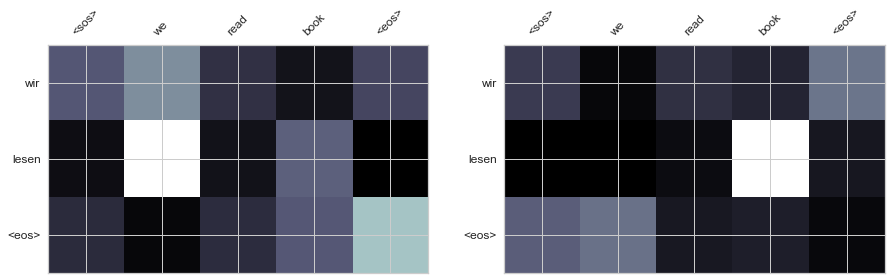

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-0.9017,  0.6584, -0.2569, -0.7741,  0.2071,  2.1448, -0.8264,
           0.3286, -1.2872, -0.4518,  0.2317, -0.3442, -0.4990, -2.0219,
           0.5940, -1.7045,  1.9103,  0.7549, -1.7414,  0.2858, -0.3417,
          -0.0154,  0.0442,  1.5871,  0.1050, -0.2556, -0.0886,  0.4069,
          -0.8530,  0.7170, -0.0843,  0.2014,  0.0759, -0.5231, -0.4612,
           0.2757,  0.1336, -0.4262,  0.5979,  0.3459, -0.4750,  0.9421,
          -0.1868, -1.3326,  0.3760,  1.4812,  2.1005, -1.2022,  0.0316,
          -0.2792,  0.2641,  0.6366,  1.9226, -0.7236, -1.5101,  1.4193,
          -0.0342, -1.4224,  1.3398, -0.6782, -0.7180, -0.0882, -2.0199,
           2.4215]]])
src = ['we', 'read', 'newspaper']
predicted trg = ['wir', 'lesen', 'zeitung', '<eos>']


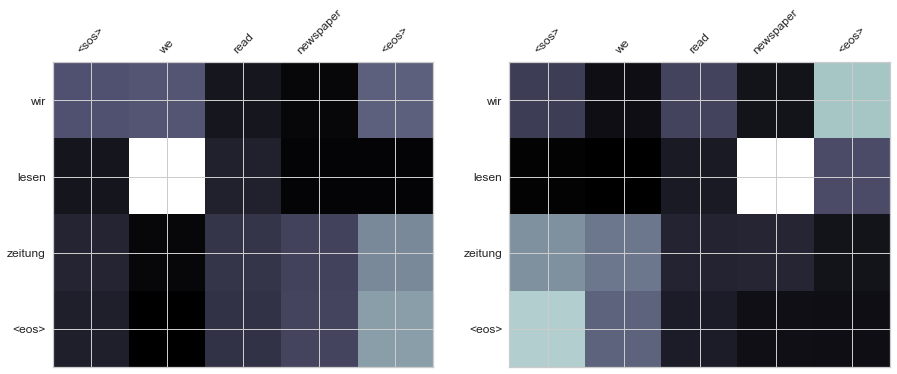

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-0.7197,  0.6837, -0.0770, -0.8533,  0.6764,  1.7710, -0.4415,
           0.2117, -1.1695, -0.6475, -0.2107, -0.4392, -0.6839, -2.2435,
           0.5878, -2.2792,  1.7688,  0.6510, -1.4407,  0.5571, -0.2183,
          -0.1168,  0.0730,  1.7598, -0.0762, -0.3282, -0.4204,  0.4027,
          -0.5432,  0.9893,  0.1987,  0.2086,  0.2875, -0.5541, -0.5658,
           0.2300, -0.1645, -0.5223,  0.4959,  0.6773, -0.5599,  1.2942,
          -0.6240, -1.1351,  0.2341,  1.2642,  2.1393, -1.2572,  0.0121,
          -0.1869,  0.3817,  0.5870,  1.9588, -0.6295, -1.6273,  1.4121,
          -0.0137, -1.3795,  1.1973, -0.6467, -0.8701,  0.1833, -1.5484,
           2.3187]]])


In [124]:
valid_sentences_embeddings = []
for i in range(len(tabular_set)):
    test_logger = test_sentence(tabular_set[i].src)
    #train_data.examples[example_idx].src
    #test_logger.get_default_summary()
    trg4 = test_logger.get_summary(labels=["DecoderLayer@trg4"],show_data=True)
    valid_sentences_embeddings.append(trg4[0].numpy().flatten())

src = ['i', 'want', 'to', 'eat', 'bread']
old attention torch.Size([1, 2, 7, 7])
old attention tensor([[[[0.0415, 0.3681, 0.0384, 0.1063, 0.2461, 0.1053, 0.0942],
          [0.3521, 0.1698, 0.2067, 0.0140, 0.0268, 0.2263, 0.0043],
          [0.0244, 0.5596, 0.0133, 0.1487, 0.1773, 0.0077, 0.0691],
          [0.0380, 0.0859, 0.0229, 0.1295, 0.1001, 0.0349, 0.5887],
          [0.2128, 0.0780, 0.0073, 0.0144, 0.0418, 0.0997, 0.5460],
          [0.1206, 0.2104, 0.4938, 0.0090, 0.1079, 0.0524, 0.0060],
          [0.0326, 0.1687, 0.0541, 0.0843, 0.1424, 0.4997, 0.0182]],

         [[0.0120, 0.0078, 0.9186, 0.0076, 0.0032, 0.0384, 0.0124],
          [0.0413, 0.1678, 0.1164, 0.0069, 0.0563, 0.5186, 0.0927],
          [0.1431, 0.0130, 0.0358, 0.3068, 0.3401, 0.0465, 0.1147],
          [0.5635, 0.0241, 0.0728, 0.0364, 0.2163, 0.0020, 0.0849],
          [0.0316, 0.0374, 0.0316, 0.0148, 0.0373, 0.0238, 0.8235],
          [0.0326, 0.0089, 0.0062, 0.0017, 0.8961, 0.0451, 0.0093],
          [0.0250, 

C:\Users\mcelikkaya\Anaconda3\envs\p37_tensor23\lib\site-packages\ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\mcelikkaya\Anaconda3\envs\p37_tensor23\lib\site-packages\ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


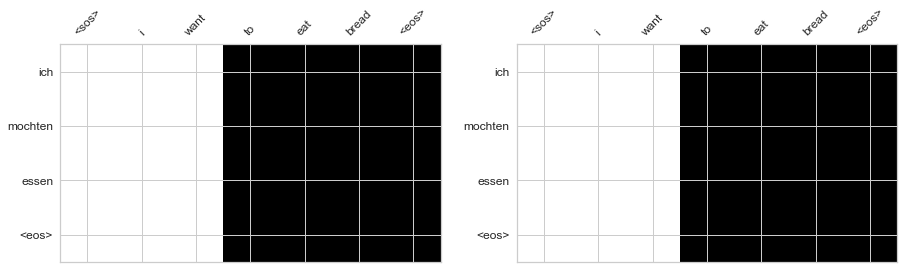

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['i', 'want', 'to', 'eat', 'apple']
old attention torch.Size([1, 2, 7, 7])
old attention tensor([[[[4.1988e-02, 3.7201e-01, 3.8808e-02, 1.0744e-01, 2.4874e-01,
           9.5845e-02, 9.5168e-02],
          [4.4784e-01, 2.1599e-01, 2.6298e-01, 1.7861e-02, 3.4141e-02,
           1.5733e-02, 5.4593e-03],
          [2.4344e-02, 5.5801e-01, 1.3295e-02, 1.4825e-01, 1.7676e-01,
           1.0424e-02, 6.8916e-02],
          [3.4790e-02, 7.8705e-02, 2.0942e-02, 1.1865e-01, 9.1674e-02,
           1.1595e-01, 5.3930e-01],
          [2.1809e-01, 7.9920e-02, 7.4703e-03, 1.4751e-02, 4.2848e-02,
           7.7389e-02, 5.5953e-01],
          [3.9561e-02, 3.1939e-01, 2.3901e-01, 5.0944e-02, 6.3972e-02,
           6.5649e-02, 2.2147e-01],
          [5.2775e-02, 2.7346e-01, 8.7654e-02, 1.3663e-01, 2.3085e-01,
           1.8913e-01, 2.9505e-02]],

         [[1.2396e-02, 8.0565e-03, 9

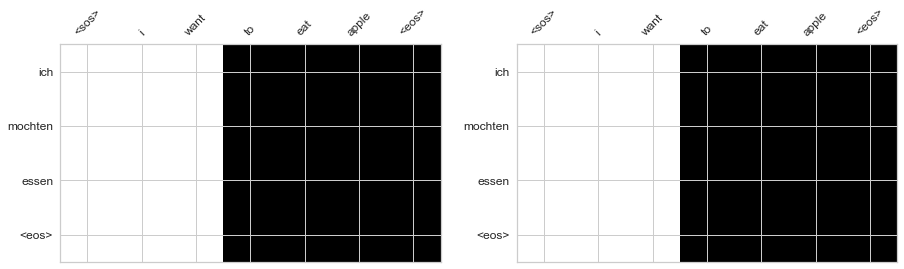

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['i', 'want', 'to', 'drink', 'water']
old attention torch.Size([1, 2, 7, 7])
old attention tensor([[[[3.0442e-02, 2.6972e-01, 2.8136e-02, 7.7895e-02, 5.0570e-01,
           1.9110e-02, 6.8999e-02],
          [8.4978e-02, 4.0985e-02, 4.9900e-02, 3.3892e-03, 8.1898e-01,
           7.3003e-04, 1.0359e-03],
          [2.8259e-02, 6.4776e-01, 1.5434e-02, 1.7210e-01, 4.6074e-03,
           5.1841e-02, 8.0001e-02],
          [4.0377e-02, 9.1345e-02, 2.4306e-02, 1.3770e-01, 4.1593e-02,
           3.8762e-02, 6.2591e-01],
          [3.2263e-03, 6.8367e-02, 5.2556e-02, 1.5770e-02, 6.3062e-03,
           1.0245e-01, 7.5133e-01],
          [8.5588e-02, 4.2902e-02, 1.5848e-01, 3.4161e-02, 6.3094e-01,
           3.8671e-02, 9.2611e-03],
          [2.7121e-02, 1.4053e-01, 4.5045e-02, 7.0213e-02, 6.9089e-01,
           1.1044e-02, 1.5163e-02]],

         [[1.1993e-02, 7.7946e-03,

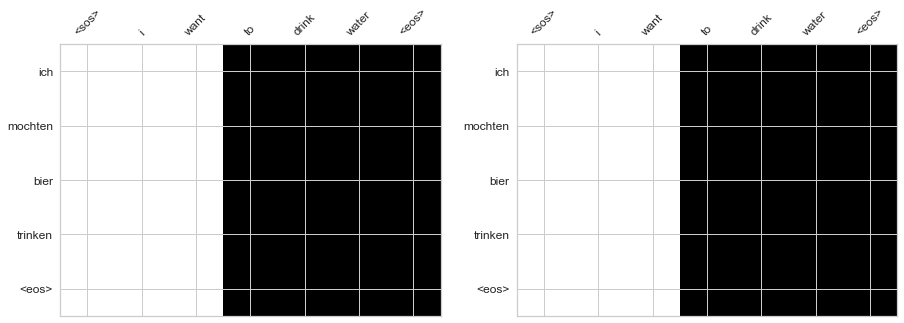

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['i', 'want', 'to', 'drink', 'beer']
old attention torch.Size([1, 2, 7, 7])
old attention tensor([[[[7.0617e-03, 6.2566e-02, 6.5268e-03, 1.8069e-02, 1.1731e-01,
           7.7246e-01, 1.6006e-02],
          [6.8173e-02, 3.2880e-02, 4.0032e-02, 2.7190e-03, 6.5703e-01,
           1.9834e-01, 8.3106e-04],
          [2.8999e-02, 6.6472e-01, 1.5838e-02, 1.7661e-01, 4.7280e-03,
           2.7017e-02, 8.2095e-02],
          [4.1186e-02, 9.3175e-02, 2.4793e-02, 1.4046e-01, 4.2426e-02,
           1.9505e-02, 6.3845e-01],
          [3.5700e-03, 7.5649e-02, 5.8154e-02, 1.7450e-02, 6.9779e-03,
           6.8369e-03, 8.3136e-01],
          [8.2364e-02, 3.1841e-02, 3.7543e-01, 3.2663e-01, 1.9677e-02,
           1.0683e-01, 5.7229e-02],
          [1.4495e-02, 7.5107e-02, 2.4075e-02, 3.7526e-02, 3.6925e-01,
           4.7144e-01, 8.1039e-03]],

         [[1.2064e-02, 7.8408e-03, 

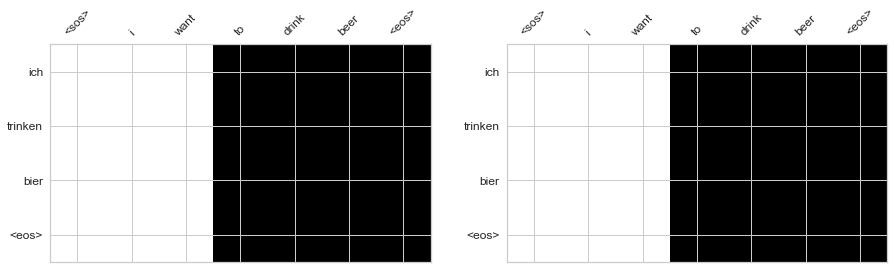

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['i', 'want', 'to', 'read', 'book']
old attention torch.Size([1, 2, 7, 7])
old attention tensor([[[[4.2110e-02, 3.7310e-01, 3.8921e-02, 1.0775e-01, 1.4333e-01,
           1.9935e-01, 9.5445e-02],
          [3.1618e-02, 1.5250e-02, 1.8566e-02, 1.2610e-03, 3.0672e-02,
           9.0225e-01, 3.8543e-04],
          [2.4610e-02, 5.6411e-01, 1.3441e-02, 1.4988e-01, 1.5030e-01,
           2.7997e-02, 6.9669e-02],
          [1.0277e-02, 2.3251e-02, 6.1867e-03, 3.5050e-02, 3.6854e-03,
           7.6223e-01, 1.5932e-01],
          [8.4879e-03, 1.7495e-04, 3.6307e-05, 2.7650e-04, 1.3620e-03,
           9.8840e-01, 1.2664e-03],
          [8.3474e-02, 2.1927e-02, 1.4598e-01, 4.2653e-01, 1.1282e-01,
           9.1552e-02, 1.1772e-01],
          [2.6430e-02, 1.3695e-01, 4.3897e-02, 6.8424e-02, 7.7254e-02,
           6.3227e-01, 1.4776e-02]],

         [[1.2467e-02, 8.1026e-03, 9

          [0.1586, 0.1586, 0.1586, 0.1311, 0.1311, 0.1311, 0.1311]]]])
predicted trg = ['ich', 'lesen', 'zeitung', 'lesen', '<eos>']


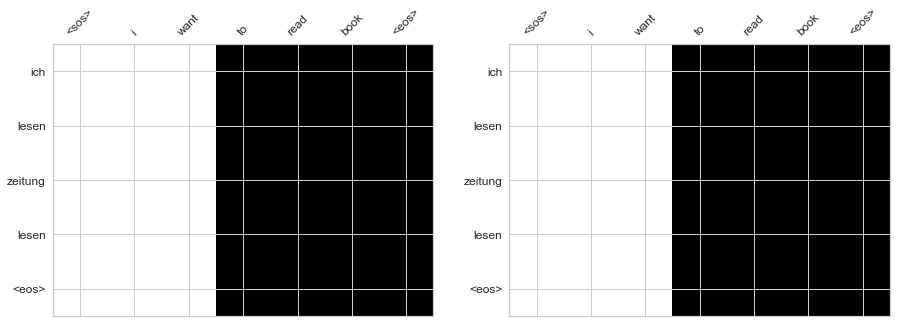

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['i', 'want', 'to', 'read', 'newspaper']
old attention torch.Size([1, 2, 7, 7])
old attention tensor([[[[1.6357e-02, 1.4493e-01, 1.5118e-02, 4.1855e-02, 5.5674e-02,
           6.8899e-01, 3.7075e-02],
          [1.3308e-01, 6.4186e-02, 7.8147e-02, 5.3077e-03, 1.2910e-01,
           5.8856e-01, 1.6223e-03],
          [2.3102e-02, 5.2955e-01, 1.2617e-02, 1.4069e-01, 1.4109e-01,
           8.7549e-02, 6.5401e-02],
          [1.8179e-02, 4.1126e-02, 1.0943e-02, 6.1998e-02, 6.5189e-03,
           5.7943e-01, 2.8181e-01],
          [3.5514e-02, 7.3201e-04, 1.5191e-04, 1.1569e-03, 5.6989e-03,
           9.5145e-01, 5.2987e-03],
          [2.6561e-01, 3.7154e-02, 4.4110e-01, 3.7559e-02, 1.8371e-01,
           1.2975e-02, 2.1894e-02],
          [1.0794e-02, 5.5928e-02, 1.7927e-02, 2.7944e-02, 3.1550e-02,
           8.4982e-01, 6.0346e-03]],

         [[1.1807e-02, 7.6738e-

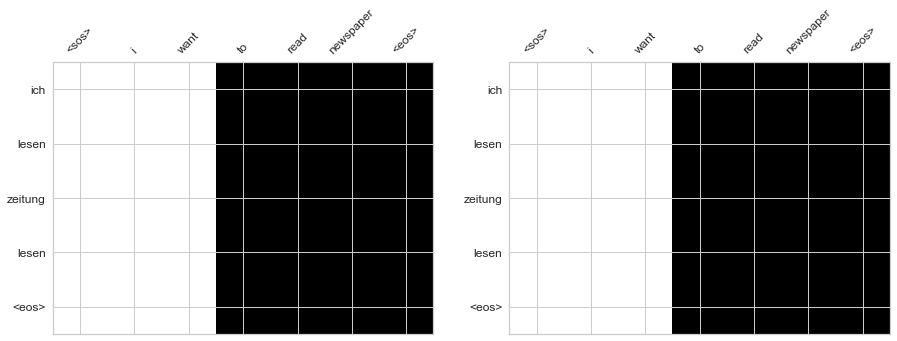

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['i', 'can', 'eat', 'bread']
old attention torch.Size([1, 2, 6, 6])
old attention tensor([[[[3.0191e-03, 2.6749e-02, 9.3236e-01, 2.3894e-02, 5.5697e-03,
           8.4044e-03],
          [1.0534e-01, 5.0805e-02, 7.7098e-01, 1.2436e-02, 5.9253e-02,
           1.1882e-03],
          [1.0971e-02, 4.8005e-02, 1.3551e-02, 1.1113e-02, 8.9543e-01,
           2.0926e-02],
          [1.6021e-01, 8.4516e-02, 2.8349e-02, 3.1632e-02, 1.1233e-01,
           5.8297e-01],
          [1.8860e-01, 2.2311e-01, 2.5135e-01, 2.7473e-01, 5.5230e-02,
           6.9836e-03],
          [1.4613e-02, 6.7941e-02, 6.7614e-01, 7.5423e-02, 1.5669e-01,
           9.1945e-03]],

         [[9.3827e-02, 6.0981e-02, 4.9924e-01, 2.9327e-02, 2.2300e-01,
           9.3625e-02],
          [1.5967e-02, 6.4939e-02, 6.7347e-01, 2.0412e-02, 1.8483e-01,
           4.0382e-02],
          [5.9674e-03, 9.1749e-0

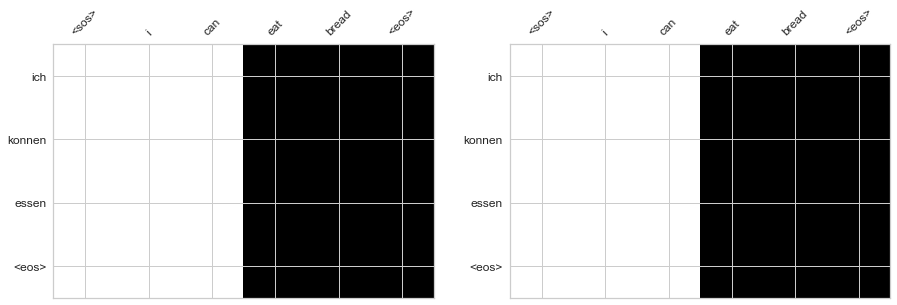

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['i', 'can', 'eat', 'apple']
old attention torch.Size([1, 2, 6, 6])
old attention tensor([[[[3.0208e-03, 2.6764e-02, 9.3288e-01, 2.3908e-02, 5.0168e-03,
           8.4091e-03],
          [1.1159e-01, 5.3820e-02, 8.1673e-01, 1.3174e-02, 3.4313e-03,
           1.2587e-03],
          [8.6450e-02, 3.7826e-01, 1.0678e-01, 8.7570e-02, 1.7605e-01,
           1.6489e-01],
          [1.5837e-01, 8.3545e-02, 2.8023e-02, 3.1269e-02, 1.2252e-01,
           5.7627e-01],
          [5.2676e-02, 2.8824e-01, 2.3646e-01, 1.5832e-01, 6.6443e-02,
           1.9786e-01],
          [1.6738e-02, 7.7822e-02, 7.7447e-01, 8.6391e-02, 3.4046e-02,
           1.0532e-02]],

         [[1.1511e-01, 7.4817e-02, 6.1251e-01, 3.5981e-02, 4.6708e-02,
           1.1487e-01],
          [1.8867e-02, 7.6732e-02, 7.9576e-01, 2.4118e-02, 3.6805e-02,
           4.7715e-02],
          [6.3010e-03, 9.6878e-0

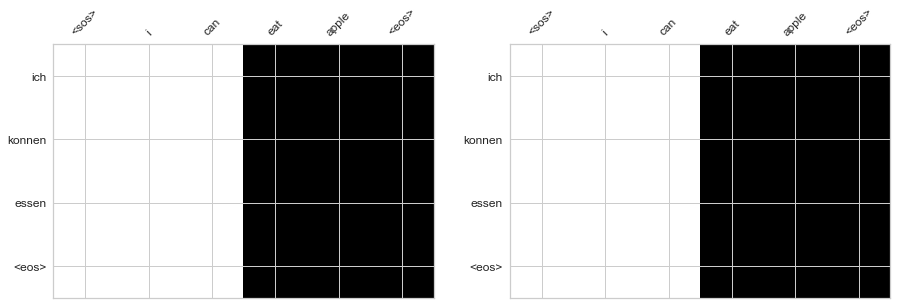

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['i', 'can', 'drink', 'water']
old attention torch.Size([1, 2, 6, 6])
old attention tensor([[[[2.9060e-03, 2.5747e-02, 8.9744e-01, 6.4493e-02, 1.3272e-03,
           8.0896e-03],
          [4.2115e-02, 2.0312e-02, 3.0824e-01, 6.2854e-01, 3.1667e-04,
           4.7504e-04],
          [7.5037e-02, 3.2833e-01, 9.2682e-02, 2.6880e-01, 9.2032e-02,
           1.4312e-01],
          [2.1084e-03, 6.4318e-02, 1.6925e-02, 4.8627e-03, 8.5027e-02,
           8.2676e-01],
          [8.4584e-02, 2.8736e-02, 9.4543e-02, 7.5840e-01, 2.7317e-02,
           6.4152e-03],
          [1.1261e-02, 5.2359e-02, 5.2107e-01, 4.0490e-01, 3.3207e-03,
           7.0858e-03]],

         [[8.4997e-02, 5.5242e-02, 4.5226e-01, 2.7438e-01, 4.8309e-02,
           8.4814e-02],
          [1.9098e-02, 7.7671e-02, 8.0550e-01, 4.6356e-02, 3.0713e-03,
           4.8299e-02],
          [6.1295e-03, 9.4240e

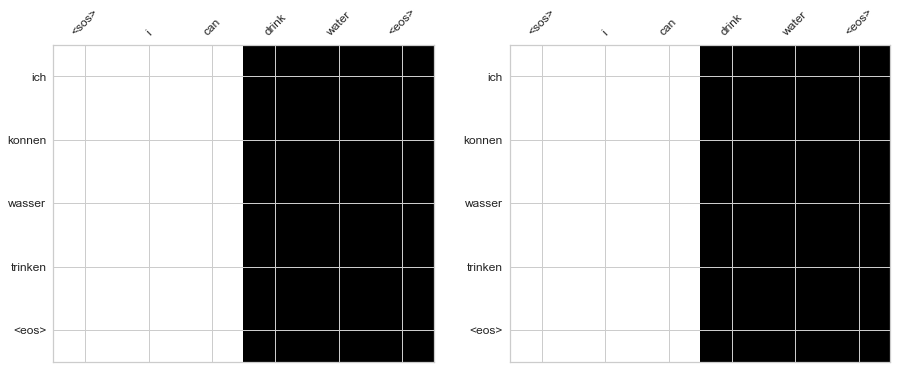

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['i', 'can', 'drink', 'beer']
old attention torch.Size([1, 2, 6, 6])
old attention tensor([[[[2.3627e-03, 2.0934e-02, 7.2966e-01, 5.2435e-02, 1.8803e-01,
           6.5772e-03],
          [3.8047e-02, 1.8350e-02, 2.7847e-01, 5.6782e-01, 9.6883e-02,
           4.2915e-04],
          [6.3601e-02, 2.7829e-01, 7.8557e-02, 2.2784e-01, 2.3041e-01,
           1.2131e-01],
          [2.2927e-03, 6.9942e-02, 1.8405e-02, 5.2878e-03, 5.0349e-03,
           8.9904e-01],
          [2.0415e-01, 5.3489e-02, 3.2580e-01, 9.0989e-02, 1.6708e-01,
           1.5850e-01],
          [9.5604e-03, 4.4451e-02, 4.4237e-01, 3.4375e-01, 1.5385e-01,
           6.0156e-03]],

         [[8.7720e-02, 5.7012e-02, 4.6674e-01, 2.8317e-01, 1.7822e-02,
           8.7531e-02],
          [1.7960e-02, 7.3045e-02, 7.5753e-01, 4.3595e-02, 6.2446e-02,
           4.5422e-02],
          [6.1004e-03, 9.3794e-

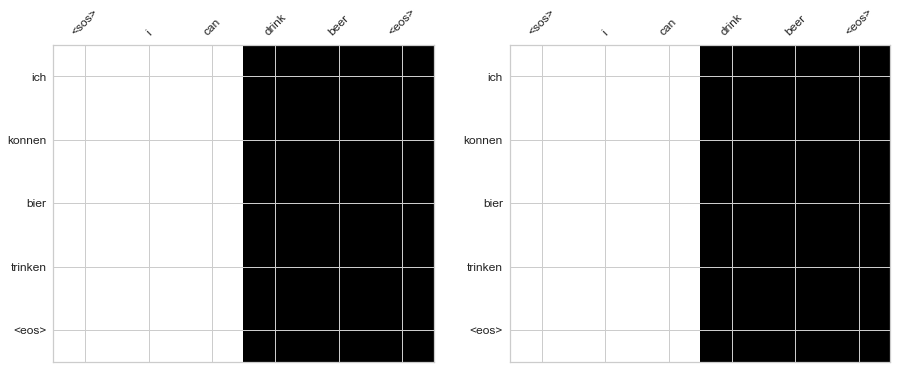

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['i', 'can', 'read', 'book']
old attention torch.Size([1, 2, 6, 6])
old attention tensor([[[[3.0353e-03, 2.6893e-02, 9.3737e-01, 1.3802e-02, 1.0454e-02,
           8.4495e-03],
          [2.8335e-02, 1.3666e-02, 2.0739e-01, 4.2566e-02, 7.0772e-01,
           3.1961e-04],
          [2.8280e-02, 1.2374e-01, 3.4930e-02, 1.8910e-01, 5.7001e-01,
           5.3939e-02],
          [9.2517e-03, 2.7452e-04, 4.7023e-02, 2.7457e-03, 9.3788e-01,
           2.8286e-03],
          [1.0823e-01, 1.9268e-02, 5.3812e-01, 6.4516e-02, 1.5357e-01,
           1.1630e-01],
          [1.5026e-02, 6.9864e-02, 6.9528e-01, 5.9654e-02, 1.5072e-01,
           9.4547e-03]],

         [[1.1978e-01, 7.7851e-02, 6.3736e-01, 3.8115e-02, 7.3662e-03,
           1.1953e-01],
          [1.9443e-02, 7.9075e-02, 8.2006e-01, 4.7660e-03, 2.7481e-02,
           4.9172e-02],
          [6.3668e-03, 9.7889e-0

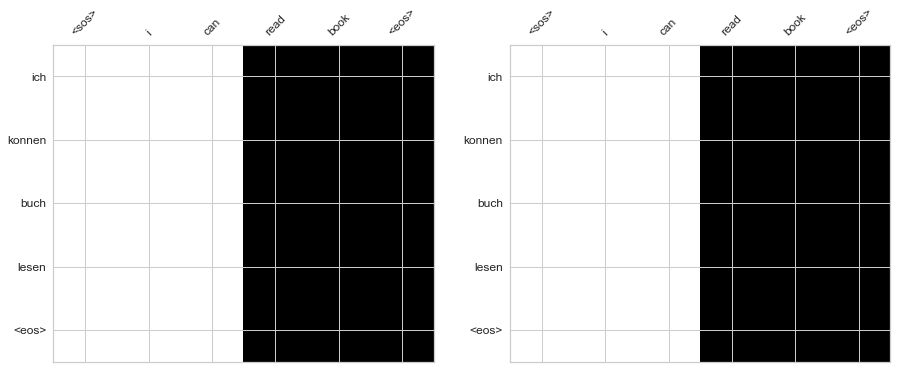

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['i', 'can', 'read', 'newspaper']
old attention torch.Size([1, 2, 6, 6])
old attention tensor([[[[2.8038e-03, 2.4842e-02, 8.6588e-01, 1.2749e-02, 8.5923e-02,
           7.8051e-03],
          [7.0493e-02, 3.3999e-02, 5.1594e-01, 1.0589e-01, 2.7288e-01,
           7.9514e-04],
          [2.6855e-02, 1.1751e-01, 3.3170e-02, 1.7958e-01, 5.9167e-01,
           5.1221e-02],
          [3.4177e-02, 1.0141e-03, 1.7371e-01, 1.0143e-02, 7.7051e-01,
           1.0449e-02],
          [5.4907e-01, 5.2055e-02, 9.1473e-02, 2.3730e-01, 3.8967e-02,
           3.1140e-02],
          [1.1276e-02, 5.2426e-02, 5.2174e-01, 4.4764e-02, 3.6270e-01,
           7.0948e-03]],

         [[8.5628e-02, 5.5652e-02, 4.5562e-01, 2.7246e-02, 2.9041e-01,
           8.5444e-02],
          [1.8811e-02, 7.6505e-02, 7.9341e-01, 4.6111e-03, 5.9093e-02,
           4.7573e-02],
          [6.3657e-03, 9.78

          [0.1825, 0.1825, 0.1825, 0.1508, 0.1508, 0.1508]]]])
predicted trg = ['ich', 'lesen', 'zeitung', 'zeitung', 'lesen', '<eos>']


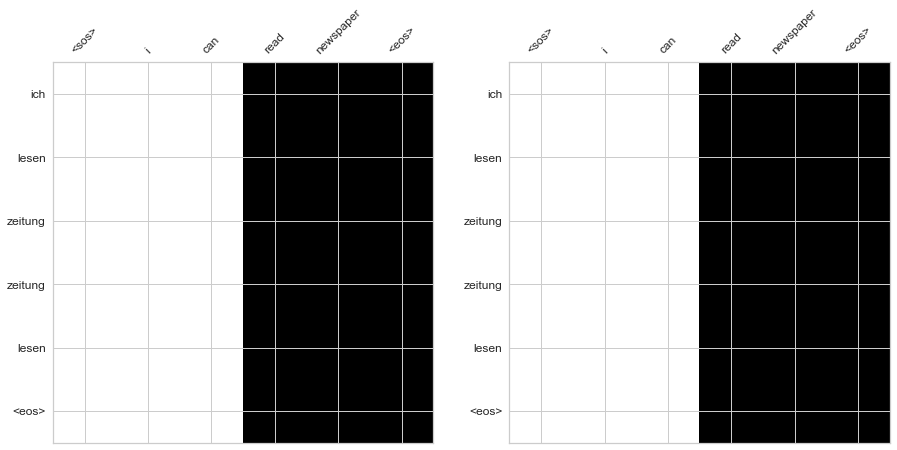

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['we', 'want', 'to', 'eat', 'bread']
old attention torch.Size([1, 2, 7, 7])
old attention tensor([[[[0.0613, 0.0675, 0.0567, 0.1569, 0.3632, 0.1555, 0.1390],
          [0.0017, 0.0027, 0.0022, 0.6864, 0.0091, 0.0429, 0.2551],
          [0.0494, 0.1081, 0.0270, 0.3011, 0.3589, 0.0155, 0.1399],
          [0.0414, 0.0026, 0.0249, 0.1413, 0.1092, 0.0381, 0.6424],
          [0.2181, 0.0551, 0.0075, 0.0148, 0.0429, 0.1021, 0.5596],
          [0.1516, 0.0071, 0.6209, 0.0113, 0.1357, 0.0659, 0.0075],
          [0.0389, 0.0063, 0.0647, 0.1008, 0.1703, 0.5973, 0.0218]],

         [[0.0101, 0.1626, 0.7753, 0.0064, 0.0027, 0.0324, 0.0105],
          [0.0672, 0.0102, 0.3593, 0.2224, 0.0452, 0.2211, 0.0747],
          [0.1443, 0.0050, 0.0361, 0.3093, 0.3428, 0.0469, 0.1156],
          [0.5497, 0.0480, 0.0710, 0.0355, 0.2110, 0.0020, 0.0828],
          [0.0310, 0.0550, 0.0310, 0

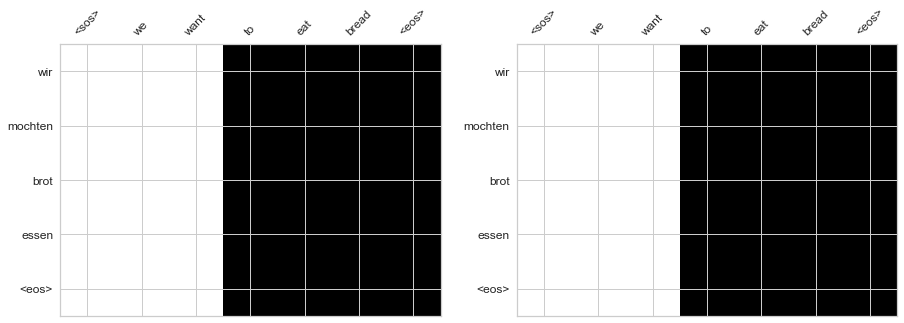

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['we', 'want', 'to', 'eat', 'apple']
old attention torch.Size([1, 2, 7, 7])
old attention tensor([[[[0.0623, 0.0686, 0.0576, 0.1594, 0.3689, 0.1422, 0.1412],
          [0.0018, 0.0028, 0.0023, 0.7137, 0.0094, 0.0049, 0.2652],
          [0.0492, 0.1075, 0.0268, 0.2994, 0.3569, 0.0210, 0.1392],
          [0.0377, 0.0024, 0.0227, 0.1285, 0.0993, 0.1256, 0.5840],
          [0.2236, 0.0565, 0.0077, 0.0151, 0.0439, 0.0794, 0.5738],
          [0.0511, 0.1208, 0.3088, 0.0658, 0.0826, 0.0848, 0.2861],
          [0.0718, 0.0116, 0.1192, 0.1859, 0.3140, 0.2573, 0.0401]],

         [[0.0104, 0.1671, 0.7967, 0.0066, 0.0028, 0.0057, 0.0108],
          [0.0828, 0.0125, 0.4427, 0.2740, 0.0557, 0.0403, 0.0920],
          [0.1425, 0.0050, 0.0357, 0.3055, 0.3386, 0.0586, 0.1142],
          [0.5440, 0.0475, 0.0702, 0.0351, 0.2088, 0.0123, 0.0819],
          [0.0317, 0.0562, 0.0317, 0

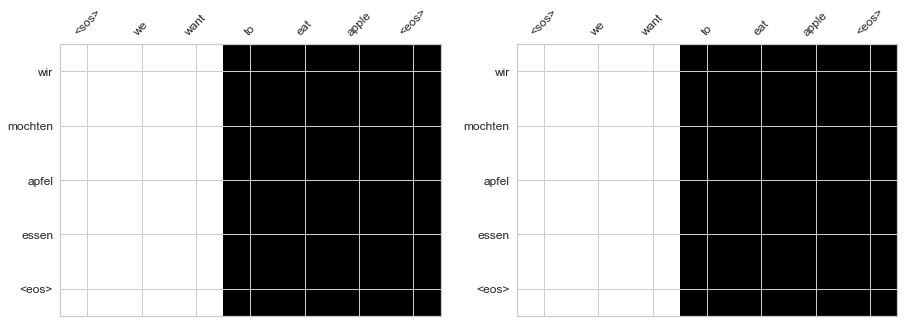

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['we', 'want', 'to', 'drink', 'water']
old attention torch.Size([1, 2, 7, 7])
old attention tensor([[[[0.0399, 0.0439, 0.0368, 0.1020, 0.6621, 0.0250, 0.0903],
          [0.0018, 0.0028, 0.0023, 0.7182, 0.0034, 0.0046, 0.2669],
          [0.0683, 0.1493, 0.0373, 0.4157, 0.0111, 0.1252, 0.1932],
          [0.0443, 0.0028, 0.0267, 0.1511, 0.0456, 0.0425, 0.6869],
          [0.0031, 0.1011, 0.0507, 0.0152, 0.0061, 0.0988, 0.7249],
          [0.0794, 0.1124, 0.1470, 0.0317, 0.5851, 0.0359, 0.0086],
          [0.0314, 0.0051, 0.0521, 0.0813, 0.7998, 0.0128, 0.0176]],

         [[0.0101, 0.1625, 0.7748, 0.0064, 0.0279, 0.0077, 0.0105],
          [0.0151, 0.0023, 0.0809, 0.0501, 0.7971, 0.0378, 0.0168],
          [0.2091, 0.0073, 0.0524, 0.4483, 0.0661, 0.0491, 0.1676],
          [0.6678, 0.0583, 0.0862, 0.0431, 0.0321, 0.0118, 0.1006],
          [0.4560, 0.0680, 0.1551,

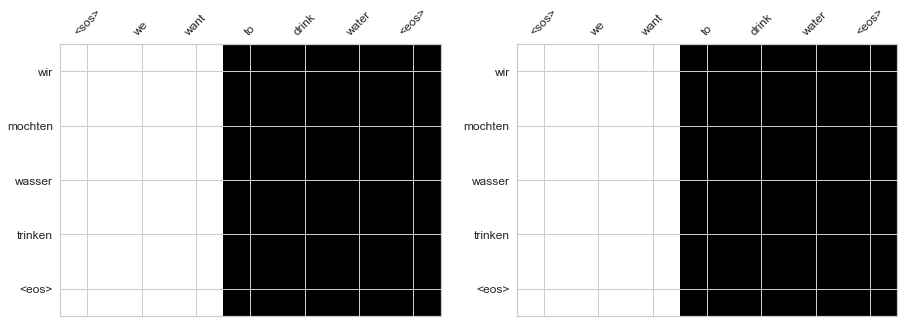

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['we', 'want', 'to', 'drink', 'beer']
old attention torch.Size([1, 2, 7, 7])
old attention tensor([[[[0.0075, 0.0082, 0.0069, 0.0191, 0.1241, 0.8172, 0.0169],
          [0.0017, 0.0027, 0.0023, 0.7040, 0.0033, 0.0242, 0.2617],
          [0.0727, 0.1591, 0.0397, 0.4429, 0.0119, 0.0678, 0.2059],
          [0.0453, 0.0028, 0.0273, 0.1545, 0.0467, 0.0214, 0.7021],
          [0.0034, 0.1115, 0.0559, 0.0168, 0.0067, 0.0066, 0.7991],
          [0.0835, 0.0182, 0.3807, 0.3312, 0.0200, 0.1083, 0.0580],
          [0.0156, 0.0025, 0.0260, 0.0405, 0.3982, 0.5084, 0.0087]],

         [[0.0102, 0.1633, 0.7787, 0.0064, 0.0281, 0.0028, 0.0105],
          [0.0152, 0.0023, 0.0811, 0.0502, 0.7990, 0.0355, 0.0169],
          [0.1888, 0.0066, 0.0473, 0.4048, 0.0597, 0.1413, 0.1514],
          [0.6663, 0.0582, 0.0860, 0.0430, 0.0321, 0.0140, 0.1004],
          [0.4604, 0.0687, 0.1566, 

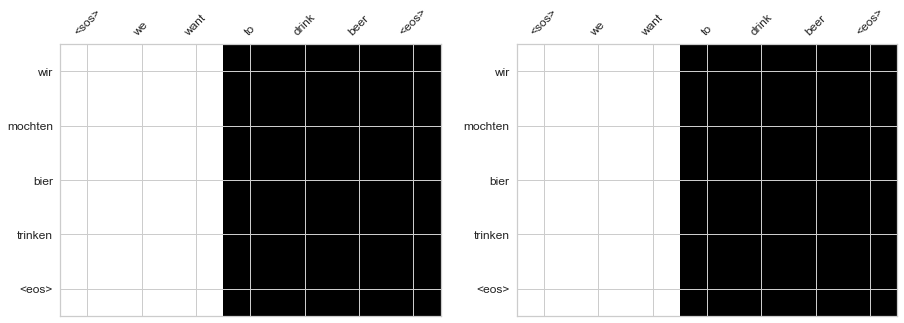

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['we', 'want', 'to', 'read', 'book']
old attention torch.Size([1, 2, 7, 7])
old attention tensor([[[[6.2546e-02, 6.8860e-02, 5.7809e-02, 1.6004e-01, 2.1288e-01,
           2.9609e-01, 1.4176e-01],
          [1.6633e-03, 2.5970e-03, 2.1705e-03, 6.7114e-01, 5.3566e-02,
           1.9442e-02, 2.4942e-01],
          [5.0254e-02, 1.0991e-01, 2.7446e-02, 3.0605e-01, 3.0691e-01,
           5.7169e-02, 1.4227e-01],
          [1.0515e-02, 6.5638e-04, 6.3298e-03, 3.5861e-02, 3.7707e-03,
           7.7986e-01, 1.6300e-01],
          [8.4881e-03, 1.4917e-04, 3.6308e-05, 2.7650e-04, 1.3621e-03,
           9.8842e-01, 1.2664e-03],
          [2.3692e-02, 7.2239e-01, 4.1433e-02, 1.2106e-01, 3.2022e-02,
           2.5985e-02, 3.3412e-02],
          [3.0472e-02, 4.9342e-03, 5.0612e-02, 7.8890e-02, 8.9071e-02,
           7.2898e-01, 1.7036e-02]],

         [[1.0458e-02, 1.6790e-01, 

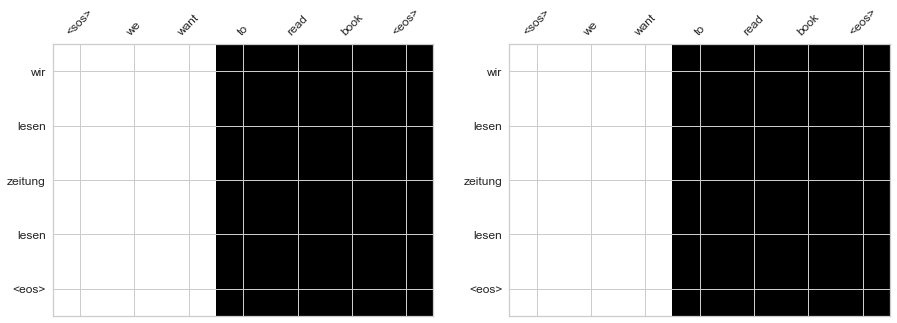

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['we', 'want', 'to', 'read', 'newspaper']
old attention torch.Size([1, 2, 7, 7])
old attention tensor([[[[1.8735e-02, 2.0626e-02, 1.7316e-02, 4.7940e-02, 6.3768e-02,
           7.8915e-01, 4.2464e-02],
          [3.4601e-04, 5.4025e-04, 4.5152e-04, 1.3962e-01, 1.1143e-02,
           7.9601e-01, 5.1888e-02],
          [4.4344e-02, 9.6982e-02, 2.4218e-02, 2.7005e-01, 2.7082e-01,
           1.6805e-01, 1.2553e-01],
          [1.8936e-02, 1.1821e-03, 1.1399e-02, 6.4581e-02, 6.7905e-03,
           6.0357e-01, 2.9355e-01],
          [3.5518e-02, 6.2420e-04, 1.5193e-04, 1.1570e-03, 5.6995e-03,
           9.5155e-01, 5.2993e-03],
          [2.0483e-01, 2.5747e-01, 3.4017e-01, 2.8965e-02, 1.4167e-01,
           1.0006e-02, 1.6884e-02],
          [1.1412e-02, 1.8479e-03, 1.8954e-02, 2.9545e-02, 3.3358e-02,
           8.9850e-01, 6.3803e-03]],

         [[9.9901e-03, 1.6039e

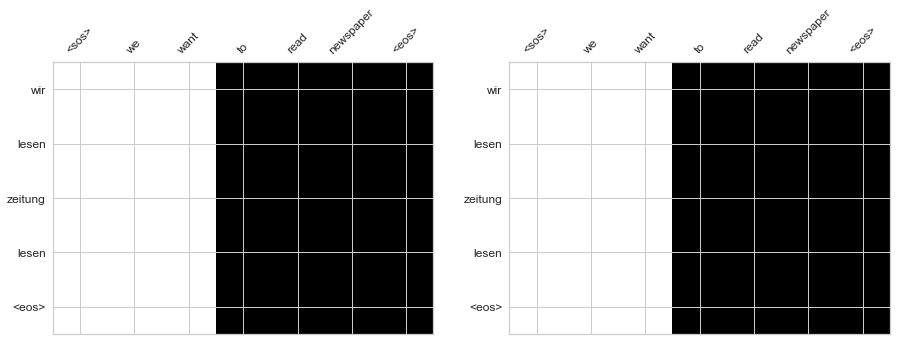

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['we', 'can', 'eat', 'bread']
old attention torch.Size([1, 2, 6, 6])
old attention tensor([[[[3.0915e-03, 3.4036e-03, 9.5473e-01, 2.4468e-02, 5.7033e-03,
           8.6060e-03],
          [5.2619e-03, 8.2156e-03, 2.8448e-03, 2.3516e-02, 1.6984e-01,
           7.9032e-01],
          [1.0137e-02, 1.2041e-01, 1.2520e-02, 1.0268e-02, 8.2733e-01,
           1.9334e-02],
          [1.6503e-01, 5.6973e-02, 2.9202e-02, 3.2584e-02, 1.1571e-01,
           6.0051e-01],
          [2.4120e-01, 6.4300e-03, 3.2145e-01, 3.5135e-01, 7.0633e-02,
           8.9314e-03],
          [1.5624e-02, 3.4402e-03, 7.2293e-01, 8.0642e-02, 1.6753e-01,
           9.8307e-03]],

         [[3.8369e-02, 6.1600e-01, 2.0416e-01, 1.1993e-02, 9.1193e-02,
           3.8287e-02],
          [1.7040e-02, 2.5814e-03, 9.0011e-01, 1.1913e-02, 5.1461e-02,
           1.6897e-02],
          [6.5438e-03, 4.0335e-

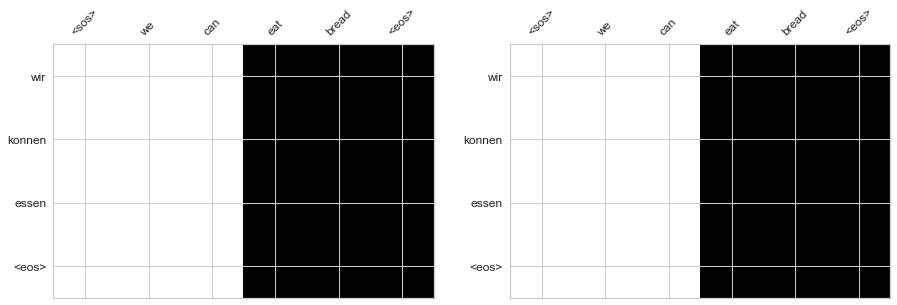

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['we', 'can', 'eat', 'apple']
old attention torch.Size([1, 2, 6, 6])
old attention tensor([[[[3.0933e-03, 3.4055e-03, 9.5527e-01, 2.4481e-02, 5.1372e-03,
           8.6109e-03],
          [6.1997e-03, 9.6799e-03, 3.3519e-03, 2.7708e-02, 2.1882e-02,
           9.3118e-01],
          [5.2438e-02, 6.2287e-01, 6.4768e-02, 5.3117e-02, 1.0679e-01,
           1.0002e-01],
          [1.6307e-01, 5.6300e-02, 2.8856e-02, 3.2199e-02, 1.2617e-01,
           5.9341e-01],
          [6.7275e-02, 9.0975e-02, 3.0199e-01, 2.0220e-01, 8.4857e-02,
           2.5270e-01],
          [1.8078e-02, 3.9806e-03, 8.3649e-01, 9.3309e-02, 3.6772e-02,
           1.1375e-02]],

         [[4.1508e-02, 6.6640e-01, 2.2086e-01, 1.2974e-02, 1.6842e-02,
           4.1419e-02],
          [1.7821e-02, 2.6998e-03, 9.4138e-01, 1.2459e-02, 7.9661e-03,
           1.7672e-02],
          [6.9470e-03, 4.2821e-

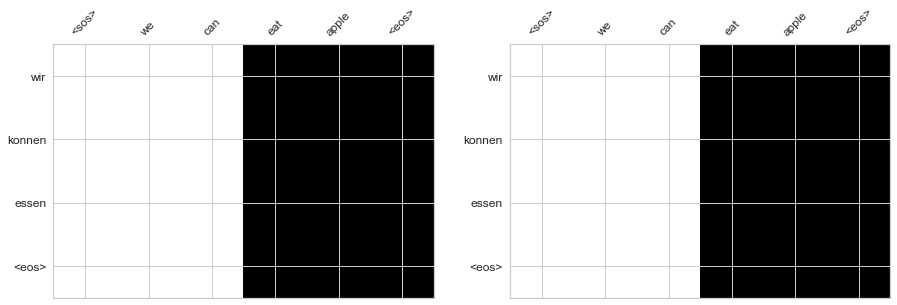

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['we', 'can', 'drink', 'water']
old attention torch.Size([1, 2, 6, 6])
old attention tensor([[[[2.9730e-03, 3.2731e-03, 9.1814e-01, 6.5980e-02, 1.3579e-03,
           8.2762e-03],
          [6.3200e-03, 9.8678e-03, 3.4169e-03, 1.0191e-02, 2.0954e-02,
           9.4925e-01],
          [4.8009e-02, 5.7026e-01, 5.9298e-02, 1.7198e-01, 5.8882e-02,
           9.1568e-02],
          [2.0484e-03, 9.0948e-02, 1.6443e-02, 4.7243e-03, 8.2608e-02,
           8.0323e-01],
          [8.1347e-02, 6.5904e-02, 9.0925e-02, 7.2938e-01, 2.6272e-02,
           6.1697e-03],
          [1.1852e-02, 2.6098e-03, 5.4843e-01, 4.2616e-01, 3.4951e-03,
           7.4578e-03]],

         [[3.6806e-02, 5.9090e-01, 1.9584e-01, 1.1881e-01, 2.0919e-02,
           3.6727e-02],
          [8.9260e-03, 1.3522e-03, 4.7151e-01, 4.8889e-01, 2.0471e-02,
           8.8512e-03],
          [6.7391e-03, 4.1539

          [0.2806, 0.0575, 0.0537, 0.2926, 0.2239, 0.0917]]]])
new attention tensor([[[[0.1825, 0.1825, 0.1825, 0.1508, 0.1508, 0.1508],
          [0.1825, 0.1825, 0.1825, 0.1508, 0.1508, 0.1508],
          [0.1825, 0.1825, 0.1825, 0.1508, 0.1508, 0.1508],
          [0.1825, 0.1825, 0.1825, 0.1508, 0.1508, 0.1508],
          [0.1825, 0.1825, 0.1825, 0.1508, 0.1508, 0.1508],
          [0.1825, 0.1825, 0.1825, 0.1508, 0.1508, 0.1508]],

         [[0.1825, 0.1825, 0.1825, 0.1508, 0.1508, 0.1508],
          [0.1825, 0.1825, 0.1825, 0.1508, 0.1508, 0.1508],
          [0.1825, 0.1825, 0.1825, 0.1508, 0.1508, 0.1508],
          [0.1825, 0.1825, 0.1825, 0.1508, 0.1508, 0.1508],
          [0.1825, 0.1825, 0.1825, 0.1508, 0.1508, 0.1508],
          [0.1825, 0.1825, 0.1825, 0.1508, 0.1508, 0.1508]]]])
old attention torch.Size([1, 2, 6, 6])
old attention tensor([[[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.1923, 0.8077, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.2930, 0.6224

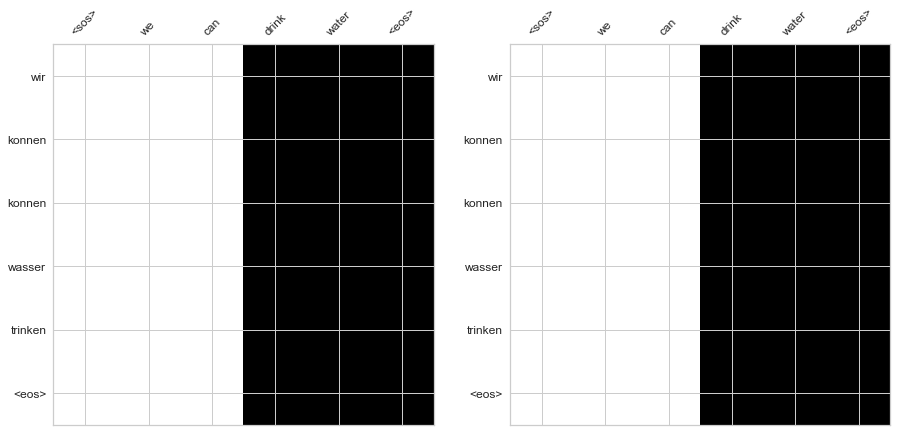

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['we', 'can', 'drink', 'beer']
old attention torch.Size([1, 2, 6, 6])
old attention tensor([[[[2.4068e-03, 2.6498e-03, 7.4328e-01, 5.3415e-02, 1.9155e-01,
           6.7000e-03],
          [5.7912e-03, 9.0421e-03, 3.1310e-03, 9.3384e-03, 1.0287e-01,
           8.6983e-01],
          [4.3055e-02, 5.1143e-01, 5.3180e-02, 1.5424e-01, 1.5598e-01,
           8.2120e-02],
          [2.2220e-03, 9.8654e-02, 1.7837e-02, 5.1246e-03, 4.8795e-03,
           8.7128e-01],
          [2.1004e-01, 2.6172e-02, 3.3520e-01, 9.3615e-02, 1.7190e-01,
           1.6307e-01],
          [9.9832e-03, 2.1982e-03, 4.6194e-01, 3.5895e-01, 1.6065e-01,
           6.2816e-03]],

         [[3.7307e-02, 5.9895e-01, 1.9851e-01, 1.2043e-01, 7.5795e-03,
           3.7227e-02],
          [8.9374e-03, 1.3540e-03, 4.7211e-01, 4.8952e-01, 1.9217e-02,
           8.8625e-03],
          [6.7040e-03, 4.1323e

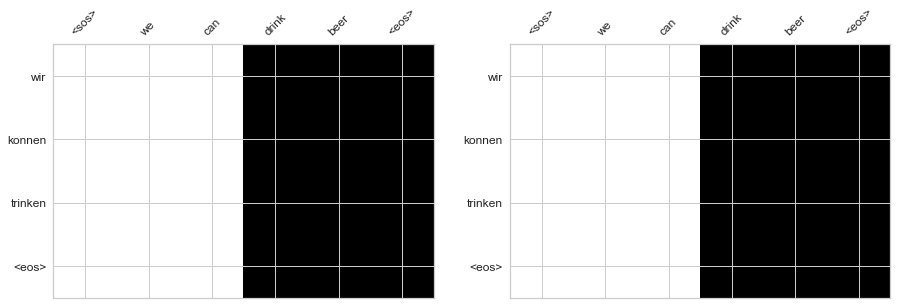

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['we', 'can', 'read', 'book']
old attention torch.Size([1, 2, 6, 6])
old attention tensor([[[[3.1085e-03, 3.4223e-03, 9.5998e-01, 1.4135e-02, 1.0706e-02,
           8.6533e-03],
          [5.1197e-03, 7.9937e-03, 2.7680e-03, 1.3851e-01, 7.6641e-02,
           7.6897e-01],
          [2.3330e-02, 2.7712e-01, 2.8816e-02, 1.5600e-01, 4.7023e-01,
           4.4497e-02],
          [9.2522e-03, 2.2223e-04, 4.7026e-02, 2.7458e-03, 9.3793e-01,
           2.8288e-03],
          [3.7723e-02, 6.5816e-01, 1.8756e-01, 2.2487e-02, 5.3529e-02,
           4.0537e-02],
          [1.6098e-02, 3.5446e-03, 7.4486e-01, 6.3907e-02, 1.6147e-01,
           1.0129e-02]],

         [[4.2100e-02, 6.7590e-01, 2.2401e-01, 1.3396e-02, 2.5889e-03,
           4.2010e-02],
          [1.7340e-02, 2.6269e-03, 9.1597e-01, 3.2644e-02, 1.4224e-02,
           1.7195e-02],
          [7.0271e-03, 4.3314e-

old attention torch.Size([1, 2, 6, 6])
old attention tensor([[[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.2644, 0.7356, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.3919, 0.5020, 0.1061, 0.0000, 0.0000, 0.0000],
          [0.2556, 0.1564, 0.1854, 0.4026, 0.0000, 0.0000],
          [0.1453, 0.0770, 0.1450, 0.4053, 0.2274, 0.0000],
          [0.2161, 0.2325, 0.0707, 0.2616, 0.1389, 0.0802]],

         [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0325, 0.9675, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0423, 0.4368, 0.5209, 0.0000, 0.0000, 0.0000],
          [0.0169, 0.3480, 0.3368, 0.2983, 0.0000, 0.0000],
          [0.0231, 0.1422, 0.5051, 0.0878, 0.2419, 0.0000],
          [0.0205, 0.2113, 0.3147, 0.0707, 0.1144, 0.2684]]]])
new attention tensor([[[[0.1825, 0.1825, 0.1825, 0.1508, 0.1508, 0.1508],
          [0.1825, 0.1825, 0.1825, 0.1508, 0.1508, 0.1508],
          [0.1825, 0.1825, 0.1825, 0.1508, 0.1508, 0.1508],
          [0.1825, 0.1825, 0

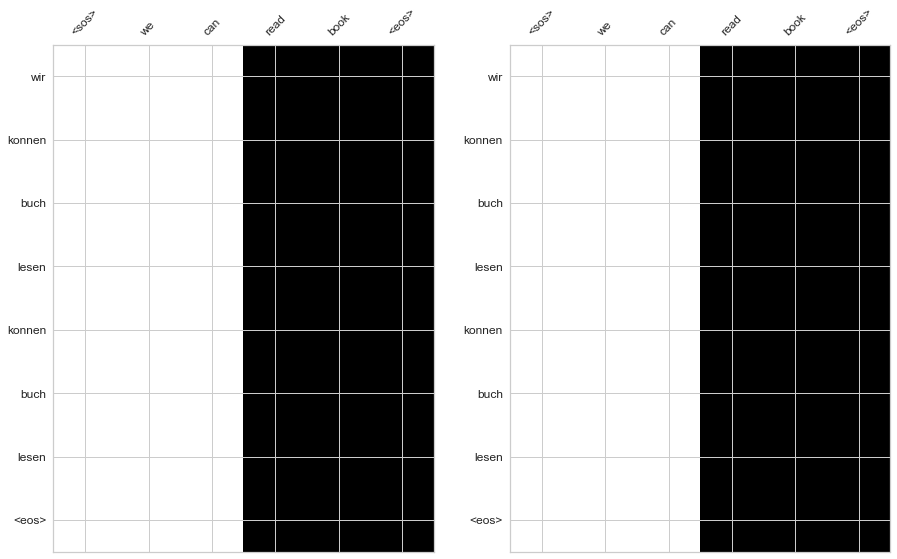

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['we', 'can', 'read', 'newspaper']
old attention torch.Size([1, 2, 6, 6])
old attention tensor([[[[2.8662e-03, 3.1555e-03, 8.8513e-01, 1.3033e-02, 8.7834e-02,
           7.9787e-03],
          [3.1984e-04, 4.9939e-04, 1.7292e-04, 8.6531e-03, 9.4232e-01,
           4.8040e-02],
          [2.2352e-02, 2.6550e-01, 2.7607e-02, 1.4946e-01, 4.9245e-01,
           4.2631e-02],
          [3.4184e-02, 8.2106e-04, 1.7374e-01, 1.0145e-02, 7.7066e-01,
           1.0451e-02],
          [4.0888e-01, 2.9409e-01, 6.8118e-02, 1.7671e-01, 2.9018e-02,
           2.3189e-02],
          [1.1868e-02, 2.6133e-03, 5.4917e-01, 4.7117e-02, 3.8177e-01,
           7.4678e-03]],

         [[3.6924e-02, 5.9279e-01, 1.9647e-01, 1.1749e-02, 1.2523e-01,
           3.6844e-02],
          [2.5634e-03, 3.8834e-04, 1.3541e-01, 4.8259e-03, 8.5427e-01,
           2.5419e-03],
          [7.0258e-03, 4.3

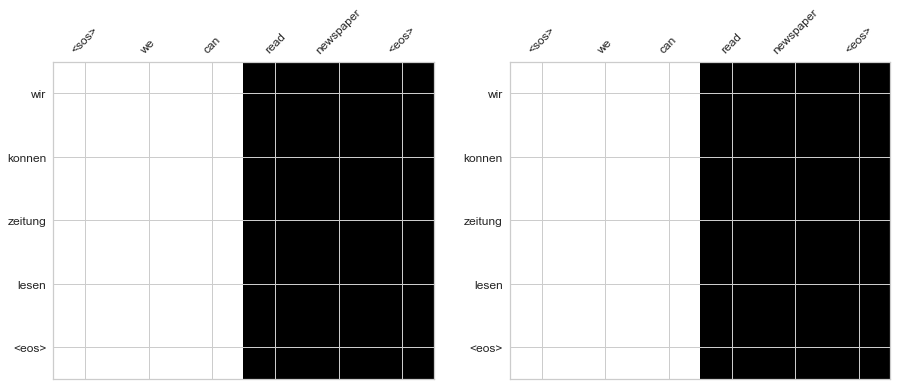

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['i', 'eat', 'bread']
old attention torch.Size([1, 2, 5, 5])
old attention tensor([[[[0.0497, 0.4402, 0.2871, 0.1224, 0.1006],
          [0.4070, 0.1963, 0.0380, 0.3546, 0.0040],
          [0.1299, 0.0870, 0.0316, 0.0861, 0.6654],
          [0.2226, 0.3791, 0.2816, 0.1044, 0.0122],
          [0.0470, 0.1480, 0.2425, 0.5482, 0.0143]],

         [[0.1798, 0.1168, 0.0701, 0.4999, 0.1333],
          [0.0514, 0.2092, 0.0615, 0.5580, 0.1198],
          [0.0427, 0.0573, 0.0451, 0.0460, 0.8089],
          [0.0497, 0.0123, 0.8383, 0.0817, 0.0181],
          [0.0797, 0.0374, 0.0844, 0.0832, 0.7153]]]])
new attention tensor([[[[0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776]],



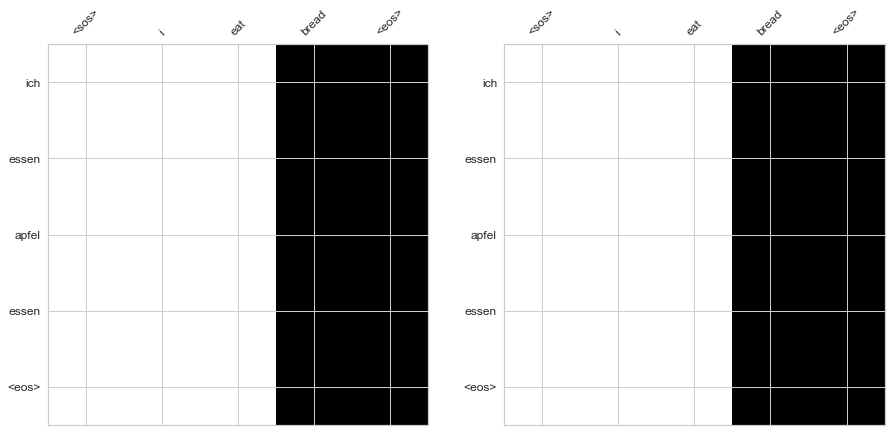

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['i', 'eat', 'apple']
old attention torch.Size([1, 2, 5, 5])
old attention tensor([[[[0.0503, 0.4456, 0.2906, 0.1116, 0.1019],
          [0.6123, 0.2953, 0.0572, 0.0292, 0.0060],
          [0.1291, 0.0864, 0.0314, 0.0921, 0.6610],
          [0.0494, 0.3889, 0.1324, 0.1657, 0.2637],
          [0.0818, 0.2577, 0.4224, 0.2132, 0.0249]],

         [[0.3071, 0.1996, 0.1198, 0.1458, 0.2277],
          [0.0960, 0.3904, 0.1147, 0.1754, 0.2236],
          [0.0446, 0.0598, 0.0471, 0.0046, 0.8439],
          [0.0012, 0.1646, 0.0188, 0.0141, 0.8012],
          [0.0733, 0.0344, 0.0775, 0.1573, 0.6575]]]])
new attention tensor([[[[0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776]],



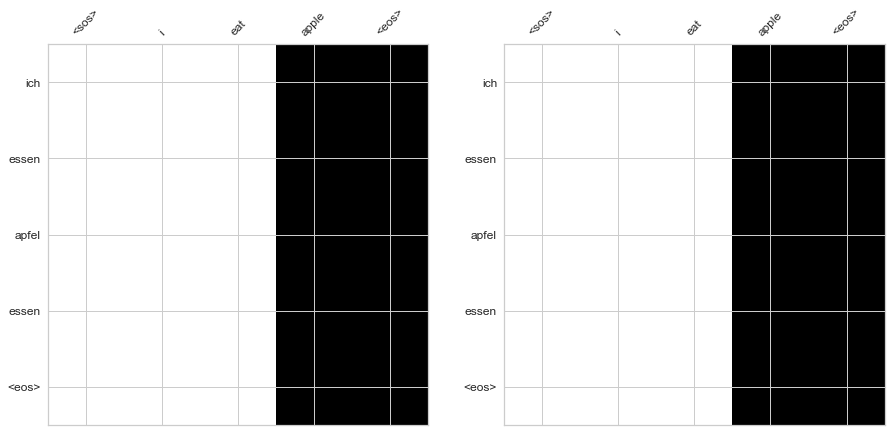

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['i', 'drink', 'water']
old attention torch.Size([1, 2, 5, 5])
old attention tensor([[[[3.4847e-02, 3.0875e-01, 5.6457e-01, 2.1263e-02, 7.0576e-02],
          [7.5075e-02, 3.6209e-02, 8.8710e-01, 8.7417e-04, 7.4119e-04],
          [2.3980e-03, 9.2839e-02, 5.1645e-03, 1.1613e-01, 7.8347e-01],
          [8.2360e-02, 4.0281e-02, 8.1625e-01, 5.0125e-02, 1.0986e-02],
          [2.6703e-02, 8.4149e-02, 8.7335e-01, 7.6729e-03, 8.1252e-03]],

         [[1.4115e-01, 9.1739e-02, 5.6858e-01, 9.3863e-02, 1.0466e-01],
          [1.0188e-01, 4.1435e-01, 2.3109e-01, 1.5352e-02, 2.3732e-01],
          [3.0065e-01, 5.7268e-01, 4.2356e-02, 1.7621e-02, 6.6692e-02],
          [5.2102e-02, 5.9935e-01, 1.2794e-01, 1.3587e-01, 8.4738e-02],
          [7.6078e-02, 3.5697e-02, 6.7406e-02, 1.3793e-01, 6.8289e-01]]]])
new attention tensor([[[[0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
        

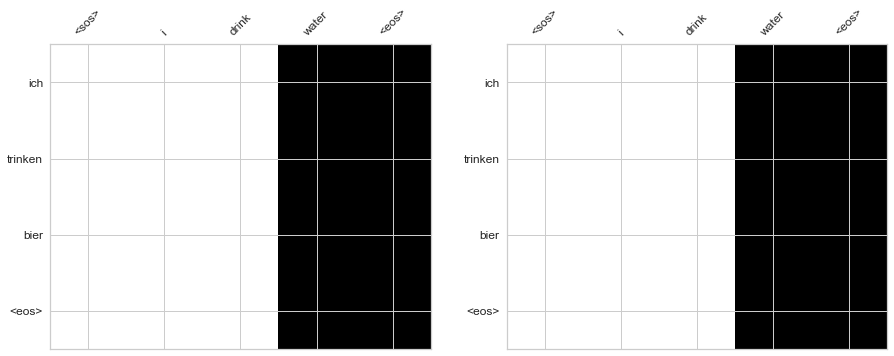

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['i', 'drink', 'beer']
old attention torch.Size([1, 2, 5, 5])
old attention tensor([[[[7.4400e-03, 6.5919e-02, 1.2054e-01, 7.9104e-01, 1.5068e-02],
          [5.7965e-02, 2.7957e-02, 6.8493e-01, 2.2857e-01, 5.7227e-04],
          [2.6985e-03, 1.0447e-01, 5.8117e-03, 5.3728e-03, 8.8164e-01],
          [2.1775e-01, 8.2136e-02, 6.7909e-02, 4.6512e-01, 1.6708e-01],
          [1.6182e-02, 5.0995e-02, 5.2926e-01, 3.9864e-01, 4.9240e-03]],

         [[1.5021e-01, 9.7627e-02, 6.0508e-01, 3.5705e-02, 1.1138e-01],
          [7.7385e-02, 3.1472e-01, 1.7553e-01, 2.5210e-01, 1.8026e-01],
          [3.0247e-01, 5.7615e-01, 4.2613e-02, 1.1670e-02, 6.7096e-02],
          [7.6649e-01, 1.2536e-02, 1.6558e-01, 5.3840e-02, 1.5607e-03],
          [5.7259e-02, 2.6867e-02, 5.0732e-02, 3.5118e-01, 5.1397e-01]]]])
new attention tensor([[[[0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
         

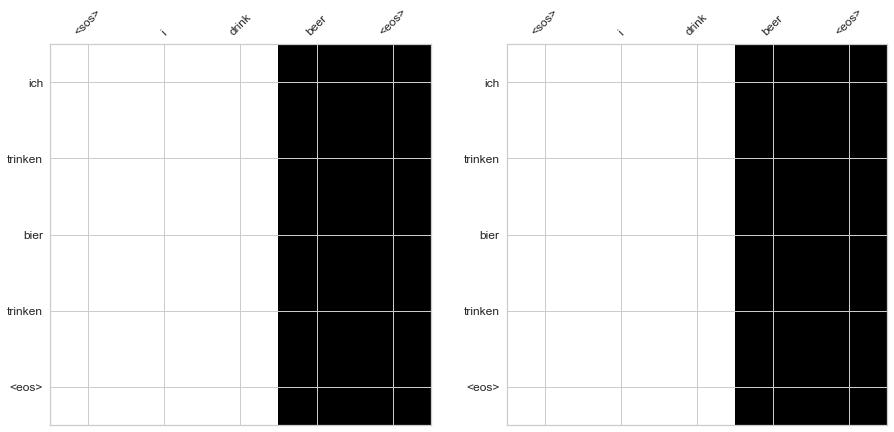

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['i', 'read', 'book']
old attention torch.Size([1, 2, 5, 5])
old attention tensor([[[[5.0490e-02, 4.4734e-01, 1.6760e-01, 2.3232e-01, 1.0226e-01],
          [2.4178e-02, 1.1661e-02, 2.8757e-02, 9.3516e-01, 2.3871e-04],
          [8.5350e-03, 3.2141e-04, 3.5886e-03, 9.8575e-01, 1.8062e-03],
          [1.6974e-01, 4.3503e-02, 2.9075e-01, 1.8941e-01, 3.0660e-01],
          [3.9132e-02, 1.2332e-01, 1.0132e-01, 7.2432e-01, 1.1907e-02]],

         [[3.4960e-01, 2.2722e-01, 1.3881e-01, 2.5153e-02, 2.5922e-01],
          [1.1173e-01, 4.5442e-01, 2.5594e-02, 1.4798e-01, 2.6027e-01],
          [3.9267e-01, 1.6759e-02, 1.1992e-02, 3.8590e-02, 5.3999e-01],
          [1.4584e-01, 1.1631e-01, 1.3748e-01, 3.8338e-01, 2.1699e-01],
          [1.4834e-02, 6.9605e-03, 8.1823e-01, 2.6821e-02, 1.3316e-01]]]])
new attention tensor([[[[0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          

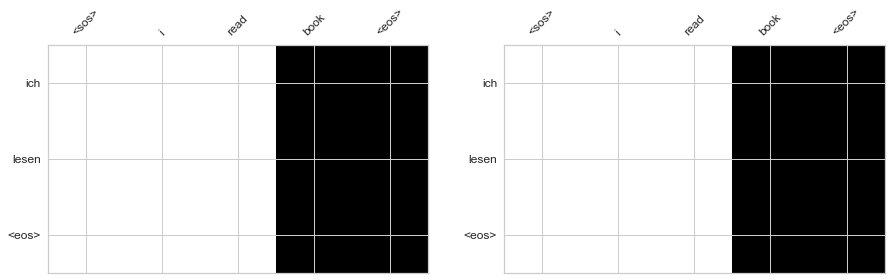

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['i', 'read', 'newspaper']
old attention torch.Size([1, 2, 5, 5])
old attention tensor([[[[0.0178, 0.1578, 0.0591, 0.7292, 0.0361],
          [0.1153, 0.0556, 0.1371, 0.6909, 0.0011],
          [0.0335, 0.0013, 0.0141, 0.9440, 0.0071],
          [0.4514, 0.0616, 0.4078, 0.0345, 0.0448],
          [0.0141, 0.0443, 0.0364, 0.9009, 0.0043]],

         [[0.1480, 0.0962, 0.0588, 0.5873, 0.1097],
          [0.0946, 0.3848, 0.0217, 0.2785, 0.2204],
          [0.3334, 0.0142, 0.0102, 0.1838, 0.4584],
          [0.0065, 0.1109, 0.5827, 0.1462, 0.1537],
          [0.0149, 0.0070, 0.8192, 0.0256, 0.1333]]]])
new attention tensor([[[[0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776

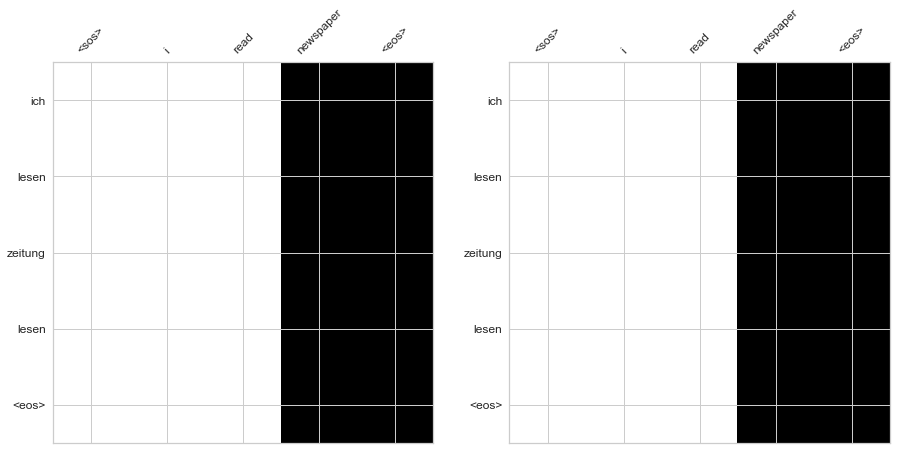

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['we', 'eat', 'bread']
old attention torch.Size([1, 2, 5, 5])
old attention tensor([[[[0.0809, 0.0890, 0.4671, 0.1993, 0.1637],
          [0.0044, 0.0069, 0.0200, 0.1197, 0.8490],
          [0.1354, 0.0490, 0.0329, 0.0897, 0.6930],
          [0.3540, 0.0129, 0.4478, 0.1659, 0.0194],
          [0.0547, 0.0069, 0.2827, 0.6390, 0.0167]],

         [[0.0477, 0.7657, 0.0186, 0.1326, 0.0354],
          [0.1699, 0.0257, 0.1166, 0.5331, 0.1546],
          [0.0427, 0.0585, 0.0450, 0.0459, 0.8079],
          [0.0499, 0.0086, 0.8415, 0.0820, 0.0181],
          [0.0753, 0.0903, 0.0797, 0.0786, 0.6760]]]])
new attention tensor([[[[0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776]],


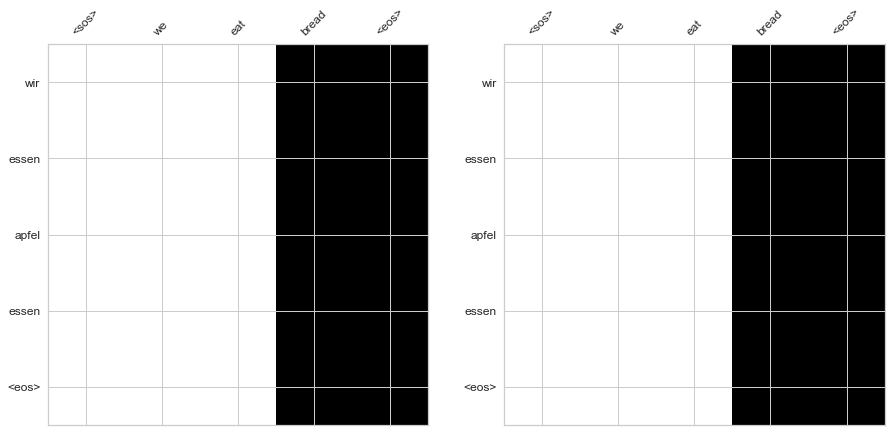

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['we', 'eat', 'apple']
old attention torch.Size([1, 2, 5, 5])
old attention tensor([[[[0.0825, 0.0908, 0.4766, 0.1830, 0.1671],
          [0.0049, 0.0077, 0.0224, 0.0146, 0.9503],
          [0.1344, 0.0487, 0.0327, 0.0959, 0.6883],
          [0.0703, 0.1299, 0.1885, 0.2359, 0.3754],
          [0.1087, 0.0137, 0.5613, 0.2833, 0.0331]],

         [[0.0536, 0.8603, 0.0209, 0.0254, 0.0397],
          [0.3113, 0.0472, 0.2137, 0.1446, 0.2832],
          [0.0445, 0.0611, 0.0470, 0.0046, 0.8428],
          [0.0014, 0.0026, 0.0225, 0.0169, 0.9566],
          [0.0695, 0.0834, 0.0736, 0.1493, 0.6241]]]])
new attention tensor([[[[0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776]],


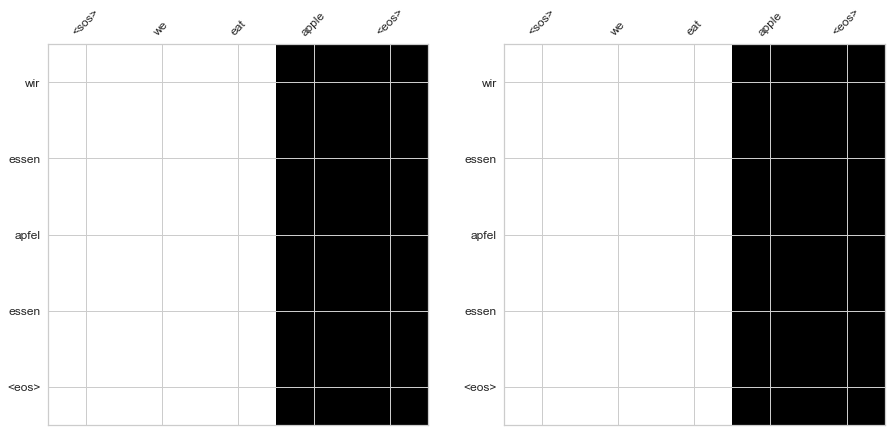

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['we', 'drink', 'water']
old attention torch.Size([1, 2, 5, 5])
old attention tensor([[[[0.0478, 0.0526, 0.7738, 0.0291, 0.0967],
          [0.0050, 0.0078, 0.0082, 0.0140, 0.9650],
          [0.0024, 0.1096, 0.0051, 0.1140, 0.7690],
          [0.0784, 0.0868, 0.7767, 0.0477, 0.0105],
          [0.0291, 0.0037, 0.9501, 0.0083, 0.0088]],

         [[0.0445, 0.7139, 0.1791, 0.0296, 0.0330],
          [0.0172, 0.0026, 0.9237, 0.0409, 0.0156],
          [0.6507, 0.0752, 0.0917, 0.0381, 0.1443],
          [0.0222, 0.8291, 0.0546, 0.0580, 0.0362],
          [0.0721, 0.0865, 0.0639, 0.1307, 0.6469]]]])
new attention tensor([[[[0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776]]

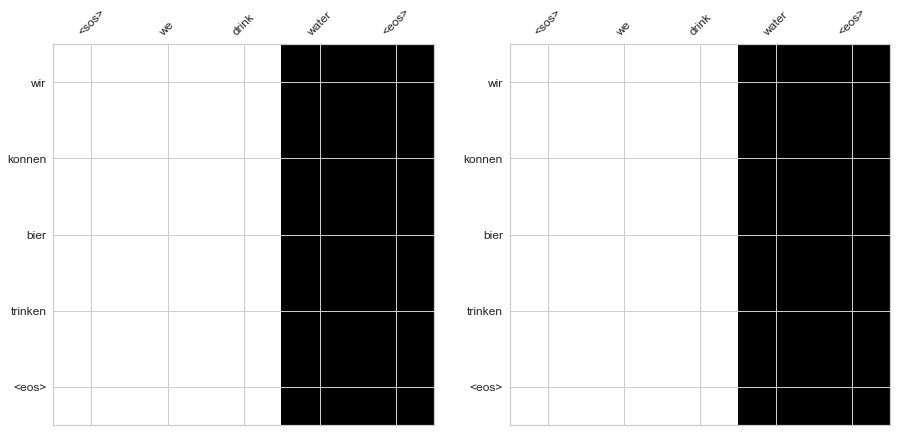

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['we', 'drink', 'beer']
old attention torch.Size([1, 2, 5, 5])
old attention tensor([[[[0.0079, 0.0087, 0.1279, 0.8395, 0.0160],
          [0.0047, 0.0074, 0.0077, 0.0706, 0.9096],
          [0.0026, 0.1231, 0.0057, 0.0053, 0.8633],
          [0.2280, 0.0388, 0.0711, 0.4871, 0.1750],
          [0.0170, 0.0021, 0.5565, 0.4192, 0.0052]],

         [[0.0453, 0.7277, 0.1826, 0.0108, 0.0336],
          [0.0172, 0.0026, 0.9260, 0.0385, 0.0157],
          [0.6593, 0.0762, 0.0929, 0.0254, 0.1462],
          [0.6948, 0.1049, 0.1501, 0.0488, 0.0014],
          [0.0550, 0.0659, 0.0487, 0.3371, 0.4933]]]])
new attention tensor([[[[0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776]],

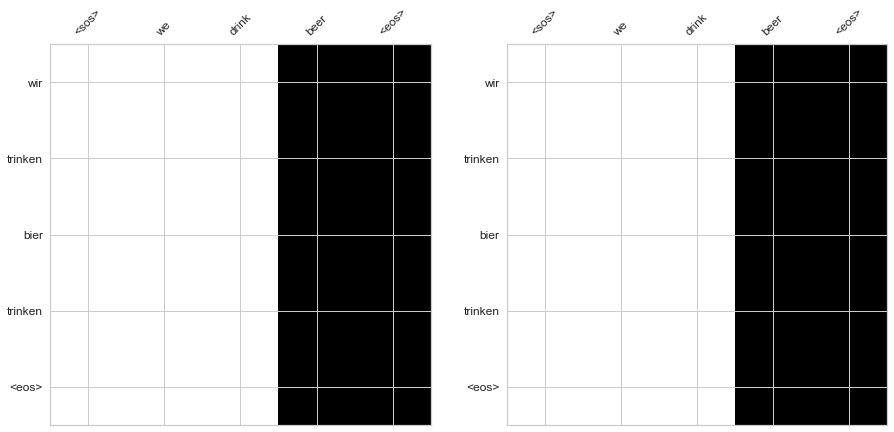

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['we', 'read', 'book']
old attention torch.Size([1, 2, 5, 5])
old attention tensor([[[[8.3008e-02, 9.1387e-02, 2.7554e-01, 3.8194e-01, 1.6812e-01],
          [4.2573e-03, 6.6472e-03, 1.1666e-01, 5.3538e-02, 8.1890e-01],
          [8.5360e-03, 2.1507e-04, 3.5890e-03, 9.8585e-01, 1.8064e-03],
          [3.3921e-02, 8.0885e-01, 5.8106e-02, 3.7853e-02, 6.1271e-02],
          [4.4387e-02, 5.5926e-03, 1.1493e-01, 8.2159e-01, 1.3506e-02]],

         [[5.4749e-02, 8.7898e-01, 2.1738e-02, 3.9391e-03, 4.0596e-02],
          [2.1002e-01, 3.1816e-02, 3.8817e-01, 1.7896e-01, 1.9103e-01],
          [3.5025e-01, 1.2298e-01, 1.0696e-02, 3.4421e-02, 4.8165e-01],
          [1.5315e-01, 7.1995e-02, 1.4438e-01, 4.0261e-01, 2.2787e-01],
          [1.4675e-02, 1.7604e-02, 8.0946e-01, 2.6533e-02, 1.3173e-01]]]])
new attention tensor([[[[0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
         

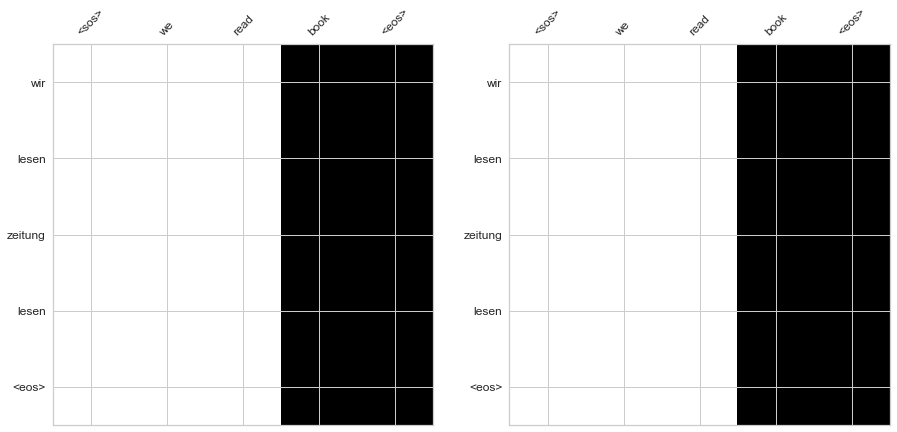

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
src = ['we', 'read', 'newspaper']
old attention torch.Size([1, 2, 5, 5])
old attention tensor([[[[2.0667e-02, 2.2753e-02, 6.8603e-02, 8.4612e-01, 4.1857e-02],
          [3.7075e-04, 5.7886e-04, 1.0159e-02, 9.1758e-01, 7.1313e-02],
          [3.3543e-02, 8.4514e-04, 1.4103e-02, 9.4441e-01, 7.0984e-03],
          [3.2657e-01, 3.2103e-01, 2.9504e-01, 2.4961e-02, 3.2399e-02],
          [1.4691e-02, 1.8510e-03, 3.8038e-02, 9.4095e-01, 4.4702e-03]],

         [[4.5124e-02, 7.2445e-01, 1.7916e-02, 1.7905e-01, 3.3459e-02],
          [2.8564e-03, 4.3273e-04, 5.2794e-03, 9.8883e-01, 2.5982e-03],
          [3.0228e-01, 1.0614e-01, 9.2314e-03, 1.6666e-01, 4.1569e-01],
          [4.6295e-03, 3.6406e-01, 4.1680e-01, 1.0454e-01, 1.0996e-01],
          [1.4693e-02, 1.7625e-02, 8.1044e-01, 2.5358e-02, 1.3189e-01]]]])
new attention tensor([[[[0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
    

new attention tensor([[[[0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776]],

         [[0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776],
          [0.2149, 0.2149, 0.2149, 0.1776, 0.1776]]]])
old attention torch.Size([1, 2, 6, 6])
old attention tensor([[[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.4817, 0.5183, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.4191, 0.2409, 0.3400, 0.0000, 0.0000, 0.0000],
          [0.2550, 0.1584, 0.3481, 0.2384, 0.0000, 0.0000],
          [0.2011, 0.1262, 0.2700, 0.1902, 0.2124, 0.0000],
    

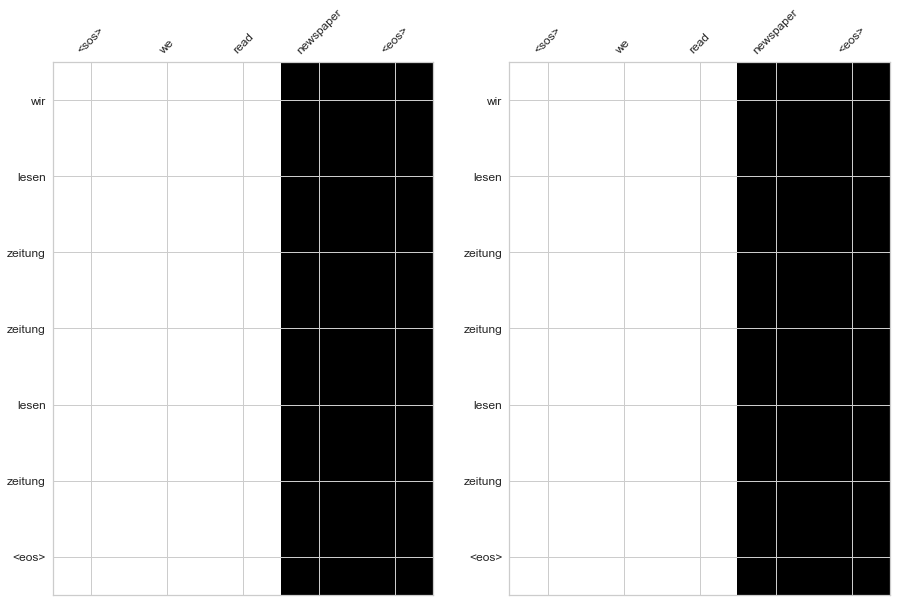

summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]


In [129]:
invalid_sentences_embeddings = []
for i in range(len(tabular_set)):
    test_logger = test_sentence(tabular_set[i].src,is_appy_attention=False)
    #train_data.examples[example_idx].src
    #test_logger.get_default_summary()
    trg4 = test_logger.get_summary(labels=["DecoderLayer@trg4"],show_data=False)
    invalid_sentences_embeddings.append(trg4[0].numpy().flatten())

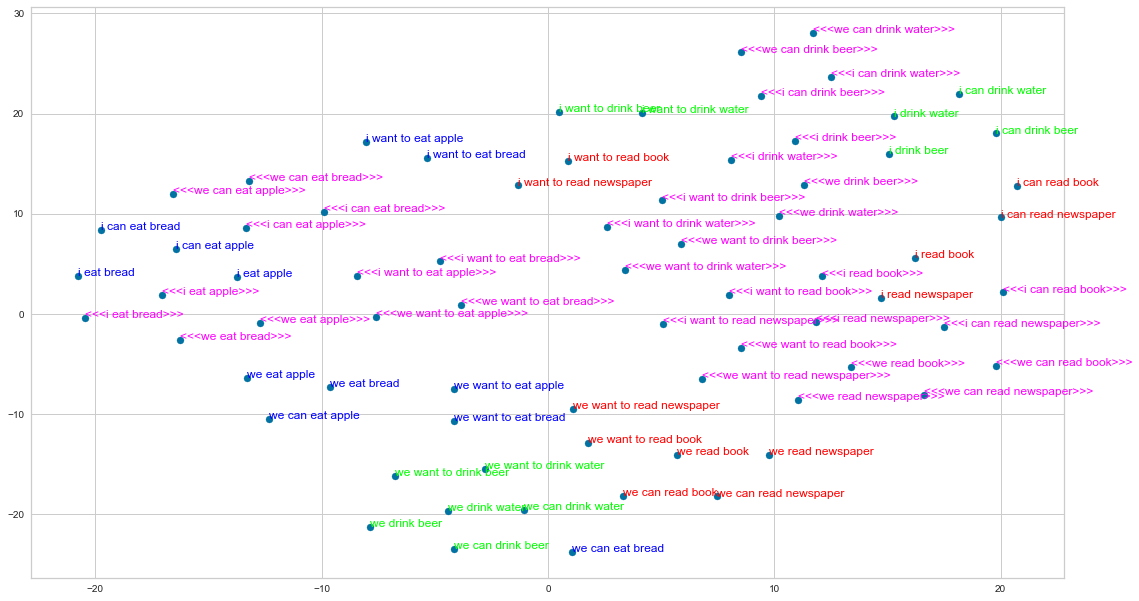

In [130]:
show_on_vis_multi(invalid_sentences_embeddings,valid_sentences,valid_sentences_embeddings,valid_sentences)

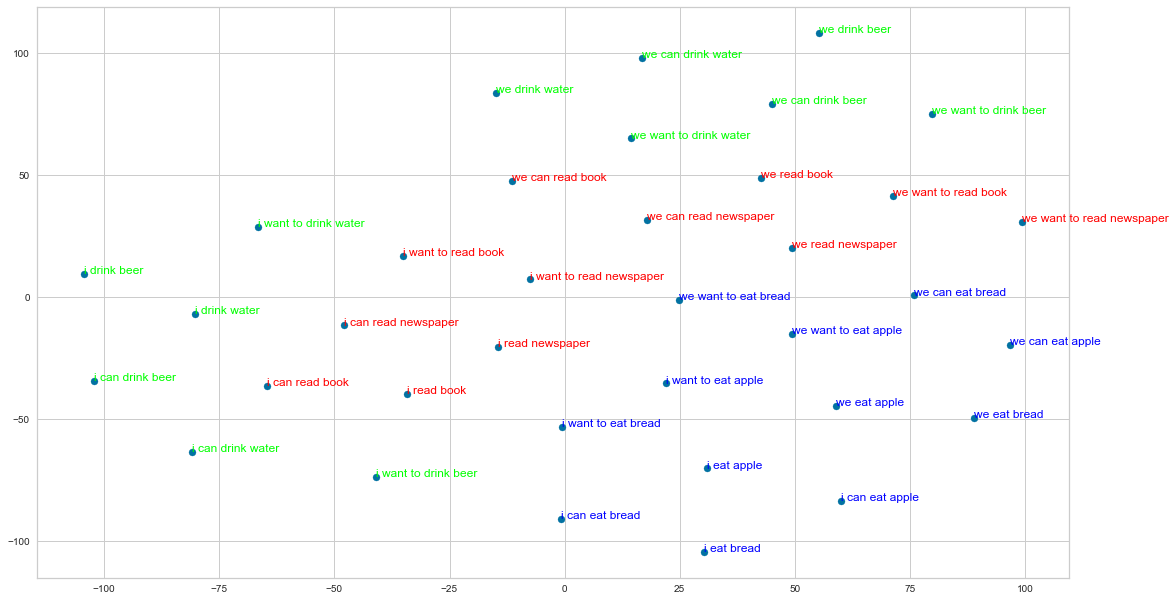

In [127]:
show_on_vis_multi([],[],valid_sentences_embeddings,valid_sentences)

(36, 64)
(36,)


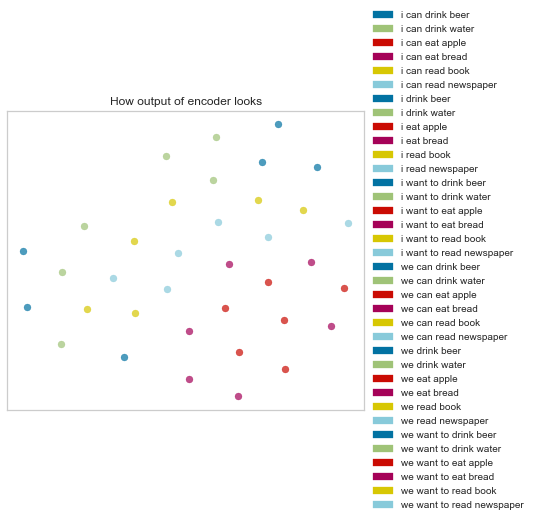

<AxesSubplot:title={'center':'How output of encoder looks'}>

In [111]:
valid_sentences = []
for i in range(len(tabular_set)):
    valid_sentences.append(" ".join( tabular_set[i].src) )
    
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
    
#all_encoder_states[0].shape
from yellowbrick.text import TSNEVisualizer
print(np.array(valid_sentences_embeddings).shape )
print(np.array(valid_sentences).shape )

Xs = valid_sentences_embeddings
Ys = valid_sentences
tsne = TSNEVisualizer(labels=valid_sentences,title="How output of encoder looks",random_state=42)

fitted = tsne.fit(np.array(Xs), Ys)
tsne.show()




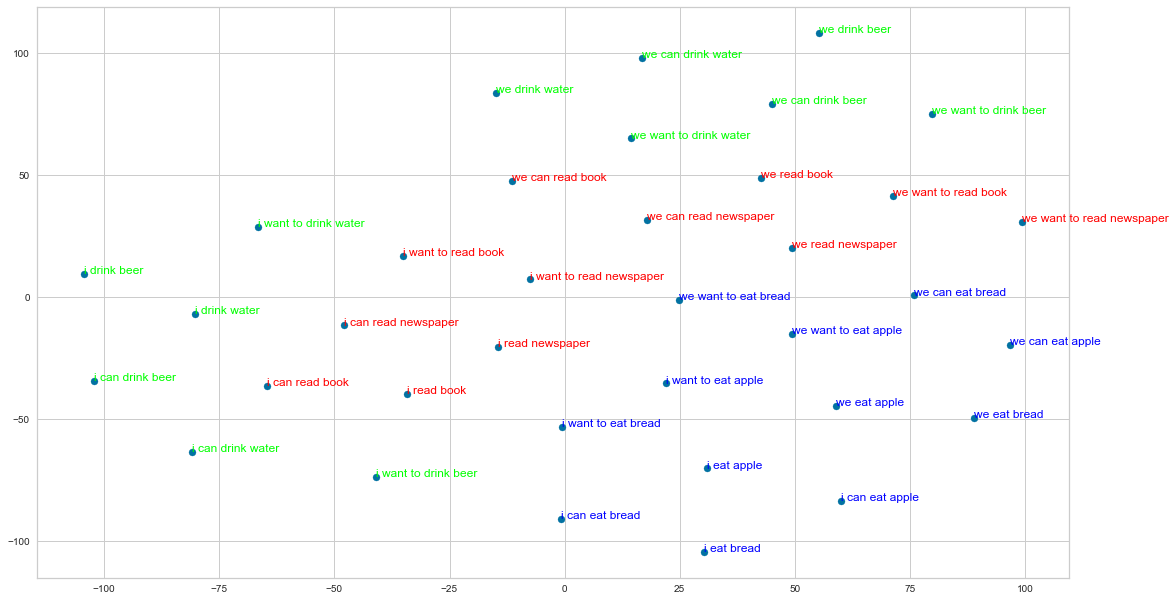

In [112]:
result = fitted.transformer_.fit_transform(np.array(valid_sentences_embeddings))

import matplotlib
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)

#scatter result words
plt.scatter(result[:, 0], result[:, 1])
words = list(valid_sentences)
#put an annotation on x,y cordinates for words
for i, word in enumerate(words):
    if "eat" in word:
        plt.annotate(word, xy=(result[i, 0], result[i, 1]),color='#0000ff')
    elif "drink" in word:
        plt.annotate(word, xy=(result[i, 0], result[i, 1]),color='#00ff00')    
    else:
        plt.annotate(word, xy=(result[i, 0], result[i, 1]),color='#ff0000')
plt.show()



using existing logger
src = ['i', 'can', 'drink', 'water']
trg = ['ich', 'konnen', 'wasser', 'trinken']
predicted trg = ['ich', 'konnen', 'wasser', 'trinken', '<eos>']


C:\Users\mcelikkaya\Anaconda3\envs\p37_tensor23\lib\site-packages\ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\mcelikkaya\Anaconda3\envs\p37_tensor23\lib\site-packages\ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


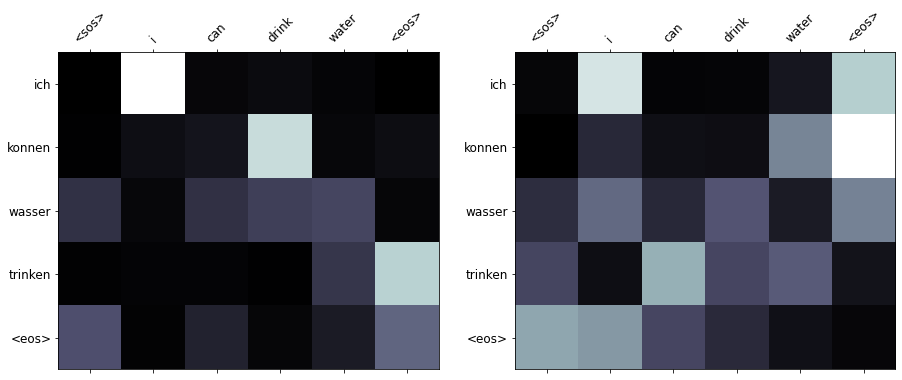

In [82]:
add_new_logger("sample1")
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

currentLogger = StepLogger(100)  
translation, attention = translate_sentence(src, SRC, TRG, model, device,is_appy_attention=True)

print(f'predicted trg = {translation}')
 
display_attention(src, translation, attention,n_heads=2,n_rows = 1, n_cols = 2)

In [44]:
loggers.keys()

dict_keys(['training', 'test_loss', 'sample1'])

In [45]:
loggers["training"].get_default_summary()


summary_count 1    self.capacity  20
0  ------------------------------------------------
Encoder@src
[8, 7]
Encoder@pos
[8, 7]
encoder@Q
[8, 2, 7, 32]
encoder@K
[8, 2, 7, 32]
encoder@V
[8, 2, 7, 32]
encoder@energy
[8, 2, 7, 7]
encoder@mask
[8, 1, 1, 7]
encoder@attention
[8, 2, 7, 7]
encoder@x1
[8, 2, 7, 32]
encoder@x2
[8, 7, 2, 32]
encoder@x3
[8, 7, 64]
encoder@x4
[8, 7, 64]
PositionwiseFeedforwardLayer@x1
[8, 7, 128]
PositionwiseFeedforwardLayer@x2
[8, 7, 64]
EncoderLayer@_src
[8, 7, 64]
EncoderLayer@src2
[8, 7, 64]
EncoderLayer@_src2
[8, 7, 64]
EncoderLayer@src3
[8, 7, 64]
EncoderLayer@src_mask
[8, 1, 1, 7]
EncoderLayer@sattention
[8, 2, 7, 7]
Encoder@src_final
[8, 7, 64]
decoder_self@Q
[8, 2, 5, 32]
decoder_self@K
[8, 2, 5, 32]
decoder_self@V
[8, 2, 5, 32]
decoder_self@energy
[8, 2, 5, 5]
decoder_self@mask
[8, 1, 5, 5]
decoder_self@attention
[8, 2, 5, 5]
decoder_self@x1
[8, 2, 5, 32]
decoder_self@x2
[8, 5, 2, 32]
decoder_self@x3
[8, 5, 64]
decoder_self@x4
[8, 5, 64]
decoder_encoder_

In [46]:
loggers["test_loss"].get_default_summary()


summary_count 1    self.capacity  20
0  ------------------------------------------------
Encoder@src
[8, 5]
Encoder@pos
[8, 5]
encoder@Q
[8, 2, 5, 32]
encoder@K
[8, 2, 5, 32]
encoder@V
[8, 2, 5, 32]
encoder@energy
[8, 2, 5, 5]
encoder@mask
[8, 1, 1, 5]
encoder@attention
[8, 2, 5, 5]
encoder@x1
[8, 2, 5, 32]
encoder@x2
[8, 5, 2, 32]
encoder@x3
[8, 5, 64]
encoder@x4
[8, 5, 64]
PositionwiseFeedforwardLayer@x1
[8, 5, 128]
PositionwiseFeedforwardLayer@x2
[8, 5, 64]
EncoderLayer@_src
[8, 5, 64]
EncoderLayer@src2
[8, 5, 64]
EncoderLayer@_src2
[8, 5, 64]
EncoderLayer@src3
[8, 5, 64]
EncoderLayer@src_mask
[8, 1, 1, 5]
EncoderLayer@sattention
[8, 2, 5, 5]
Encoder@src_final
[8, 5, 64]
decoder_self@Q
[8, 2, 4, 32]
decoder_self@K
[8, 2, 4, 32]
decoder_self@V
[8, 2, 4, 32]
decoder_self@energy
[8, 2, 4, 4]
decoder_self@mask
[8, 1, 4, 4]
decoder_self@attention
[8, 2, 4, 4]
decoder_self@x1
[8, 2, 4, 32]
decoder_self@x2
[8, 4, 2, 32]
decoder_self@x3
[8, 4, 64]
decoder_self@x4
[8, 4, 64]
decoder_encoder_

In [47]:
loggers["sample1"].get_default_summary()


summary_count 1    self.capacity  20
0  ------------------------------------------------
Encoder@src
[1, 6]
Encoder@pos
[1, 6]
encoder@Q
[1, 2, 6, 32]
encoder@K
[1, 2, 6, 32]
encoder@V
[1, 2, 6, 32]
encoder@energy
[1, 2, 6, 6]
encoder@mask
[1, 1, 1, 6]
encoder@attention
[1, 2, 6, 6]
encoder@x1
[1, 2, 6, 32]
encoder@x2
[1, 6, 2, 32]
encoder@x3
[1, 6, 64]
encoder@x4
[1, 6, 64]
PositionwiseFeedforwardLayer@x1
[1, 6, 128]
PositionwiseFeedforwardLayer@x2
[1, 6, 64]
EncoderLayer@_src
[1, 6, 64]
EncoderLayer@src2
[1, 6, 64]
EncoderLayer@_src2
[1, 6, 64]
EncoderLayer@src3
[1, 6, 64]
EncoderLayer@src_mask
[1, 1, 1, 6]
EncoderLayer@sattention
[1, 2, 6, 6]
Encoder@src_final
[1, 6, 64]
decoder_self@Q
[1, 2, 1, 32]
decoder_self@K
[1, 2, 1, 32]
decoder_self@V
[1, 2, 1, 32]
decoder_self@energy
[1, 2, 1, 1]
decoder_self@mask
[1, 1, 1, 1]
decoder_self@attention
[1, 2, 1, 1]
decoder_self@x1
[1, 2, 1, 32]
decoder_self@x2
[1, 1, 2, 32]
decoder_self@x3
[1, 1, 64]
decoder_self@x4
[1, 1, 64]
decoder_encoder_

In [48]:
current_logger.get_default_summary(show_data=False)

summary_count 1    self.capacity  20
0  ------------------------------------------------
Encoder@src
[1, 6]
Encoder@pos
[1, 6]
encoder@Q
[1, 2, 6, 32]
encoder@K
[1, 2, 6, 32]
encoder@V
[1, 2, 6, 32]
encoder@energy
[1, 2, 6, 6]
encoder@mask
[1, 1, 1, 6]
encoder@attention
[1, 2, 6, 6]
encoder@x1
[1, 2, 6, 32]
encoder@x2
[1, 6, 2, 32]
encoder@x3
[1, 6, 64]
encoder@x4
[1, 6, 64]
PositionwiseFeedforwardLayer@x1
[1, 6, 128]
PositionwiseFeedforwardLayer@x2
[1, 6, 64]
EncoderLayer@_src
[1, 6, 64]
EncoderLayer@src2
[1, 6, 64]
EncoderLayer@_src2
[1, 6, 64]
EncoderLayer@src3
[1, 6, 64]
EncoderLayer@src_mask
[1, 1, 1, 6]
EncoderLayer@sattention
[1, 2, 6, 6]
Encoder@src_final
[1, 6, 64]
decoder_self@Q
[1, 2, 1, 32]
decoder_self@K
[1, 2, 1, 32]
decoder_self@V
[1, 2, 1, 32]
decoder_self@energy
[1, 2, 1, 1]
decoder_self@mask
[1, 1, 1, 1]
decoder_self@attention
[1, 2, 1, 1]
decoder_self@x1
[1, 2, 1, 32]
decoder_self@x2
[1, 1, 2, 32]
decoder_self@x3
[1, 1, 64]
decoder_self@x4
[1, 1, 64]
decoder_encoder_

In [49]:
#currentLogger.get_default_summary(show_data=False)

In [50]:

#currentLogger.get_summary(labels=["Q"],show_data=True)

In [51]:
loggers.keys()

dict_keys(['training', 'test_loss', 'sample1'])

In [52]:
loggers["sample1"].get_default_summary(show_data=False)

summary_count 1    self.capacity  20
0  ------------------------------------------------
Encoder@src
[1, 6]
Encoder@pos
[1, 6]
encoder@Q
[1, 2, 6, 32]
encoder@K
[1, 2, 6, 32]
encoder@V
[1, 2, 6, 32]
encoder@energy
[1, 2, 6, 6]
encoder@mask
[1, 1, 1, 6]
encoder@attention
[1, 2, 6, 6]
encoder@x1
[1, 2, 6, 32]
encoder@x2
[1, 6, 2, 32]
encoder@x3
[1, 6, 64]
encoder@x4
[1, 6, 64]
PositionwiseFeedforwardLayer@x1
[1, 6, 128]
PositionwiseFeedforwardLayer@x2
[1, 6, 64]
EncoderLayer@_src
[1, 6, 64]
EncoderLayer@src2
[1, 6, 64]
EncoderLayer@_src2
[1, 6, 64]
EncoderLayer@src3
[1, 6, 64]
EncoderLayer@src_mask
[1, 1, 1, 6]
EncoderLayer@sattention
[1, 2, 6, 6]
Encoder@src_final
[1, 6, 64]
decoder_self@Q
[1, 2, 1, 32]
decoder_self@K
[1, 2, 1, 32]
decoder_self@V
[1, 2, 1, 32]
decoder_self@energy
[1, 2, 1, 1]
decoder_self@mask
[1, 1, 1, 1]
decoder_self@attention
[1, 2, 1, 1]
decoder_self@x1
[1, 2, 1, 32]
decoder_self@x2
[1, 1, 2, 32]
decoder_self@x3
[1, 1, 64]
decoder_self@x4
[1, 1, 64]
decoder_encoder_

In [68]:
attention_orig = loggers["sample1"].get_summary(labels=["decoder_encoder_attention@attention"],show_data=True)
trg4 = loggers["sample1"].get_summary(labels=["DecoderLayer@trg4"],show_data=True)

summary_count 1    self.capacity  20
0  ------------------------------------------------
decoder_encoder_attention@attention
[1, 2, 1, 6]
tensor([[[[0.5265, 0.1429, 0.0457, 0.0419, 0.1965, 0.0465]],

         [[0.1411, 0.4008, 0.0722, 0.0750, 0.2525, 0.0584]]]])
summary_count 1    self.capacity  20
0  ------------------------------------------------
DecoderLayer@trg4
[1, 1, 64]
tensor([[[-1.4940e+00, -1.5930e-01, -1.0580e+00, -1.0116e+00,  9.1183e-01,
           2.2354e+00, -1.5837e-01,  3.4703e-01, -6.4350e-01,  6.9168e-01,
           3.9615e-01, -5.1642e-01, -6.9277e-01, -2.2253e+00,  1.0529e+00,
          -1.7562e-01,  6.2090e-01,  1.2872e+00,  8.6541e-02, -9.4496e-02,
           2.3152e-01, -7.8664e-01, -1.9133e-01, -4.3388e-01,  9.4037e-01,
          -6.7833e-01, -6.3566e-01,  2.8480e-01, -5.0138e-01,  5.0984e-01,
           4.7199e-01,  9.1885e-02,  2.4657e-01, -3.8347e-01, -5.5224e-01,
           4.2976e-01,  5.4698e-01, -4.6524e-01,  8.0617e-01, -4.1947e-01,
           3.2164e-

In [54]:
attention_orig[0].dtype

torch.float32

In [55]:
np.full((2, 2), 1/6)

array([[0.16666667, 0.16666667],
       [0.16666667, 0.16666667]])

In [56]:
tt = torch.tensor(np.full((1, 2, 1, 6), 1/6) )

In [57]:
tt.shape[3]

6

In [58]:
torch.tensor(np.full((1, 2, 1, 6), 1/tt.shape[3]) )

tensor([[[[0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667]],

         [[0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667]]]],
       dtype=torch.float64)

src = ['we', 'can', 'eat', 'bread']
trg = ['wir', 'konnen', 'brot', 'essen']
old attention torch.Size([1, 2, 6, 6])
old attention tensor([[[[3.0915e-03, 3.4036e-03, 9.5473e-01, 2.4468e-02, 5.7033e-03,
           8.6060e-03],
          [5.2619e-03, 8.2156e-03, 2.8448e-03, 2.3516e-02, 1.6984e-01,
           7.9032e-01],
          [1.0137e-02, 1.2041e-01, 1.2520e-02, 1.0268e-02, 8.2733e-01,
           1.9334e-02],
          [1.6503e-01, 5.6973e-02, 2.9202e-02, 3.2584e-02, 1.1571e-01,
           6.0051e-01],
          [2.4120e-01, 6.4300e-03, 3.2145e-01, 3.5135e-01, 7.0633e-02,
           8.9314e-03],
          [1.5624e-02, 3.4402e-03, 7.2293e-01, 8.0642e-02, 1.6753e-01,
           9.8307e-03]],

         [[3.8369e-02, 6.1600e-01, 2.0416e-01, 1.1993e-02, 9.1193e-02,
           3.8287e-02],
          [1.7040e-02, 2.5814e-03, 9.0011e-01, 1.1913e-02, 5.1461e-02,
           1.6897e-02],
          [6.5438e-03, 4.0335e-03, 9.1458e-01, 9.0594e-03, 6.5524e-02,
           2.5845e-04],
          [3.

          [0.0785, 0.9215]]]])
new attention tensor([[[[1.0000, 0.0000],
          [0.5808, 0.4192]],

         [[1.0000, 0.0000],
          [0.0785, 0.9215]]]])
old attention torch.Size([1, 2, 2, 6])
old attention tensor([[[[0.0763, 0.4716, 0.1819, 0.1117, 0.1109, 0.0476],
          [0.0287, 0.3707, 0.2062, 0.2213, 0.1149, 0.0582]],

         [[0.0310, 0.0515, 0.0193, 0.1040, 0.1658, 0.6284],
          [0.0114, 0.0195, 0.0783, 0.1099, 0.1704, 0.6105]]]])
new attention tensor([[[[0.1825, 0.1825, 0.1825, 0.1508, 0.1508, 0.1508],
          [0.1825, 0.1825, 0.1825, 0.1508, 0.1508, 0.1508]],

         [[0.1825, 0.1825, 0.1825, 0.1508, 0.1508, 0.1508],
          [0.1825, 0.1825, 0.1825, 0.1508, 0.1508, 0.1508]]]])
old attention torch.Size([1, 2, 3, 3])
old attention tensor([[[[1.0000, 0.0000, 0.0000],
          [0.0548, 0.9452, 0.0000],
          [0.0140, 0.1149, 0.8711]],

         [[1.0000, 0.0000, 0.0000],
          [0.0098, 0.9902, 0.0000],
          [0.0047, 0.0052, 0.9901]]]])
new att

C:\Users\mcelikkaya\Anaconda3\envs\p37_tensor23\lib\site-packages\ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\mcelikkaya\Anaconda3\envs\p37_tensor23\lib\site-packages\ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


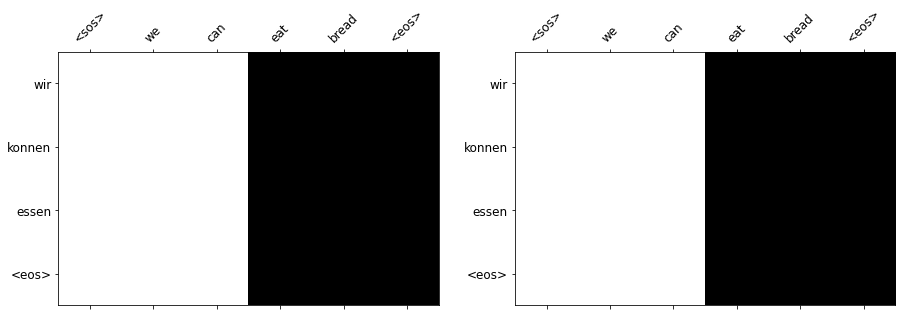

In [59]:
add_new_logger("sample3")
example_idx = 18

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

currentLogger = StepLogger(100)  
translation, attention = translate_sentence(src, SRC, TRG, model, device,is_appy_attention=False)

print(f'predicted trg = {translation}')
 
display_attention(src, translation, attention,n_heads=2,n_rows = 1, n_cols = 2)

In [67]:

for i in range( len(tabular_set)):
    print(" ".join(tabular_set[i].src))
    

i want to eat bread
ich mochten brot essen
i want to eat apple
ich mochten apfel essen
i want to drink water
ich mochten wasser trinken
i want to drink beer
ich mochten bier trinken
i want to read book
ich mochten buch lesen
i want to read newspaper
ich mochten zeitung lesen
i can eat bread
ich konnen brot essen
i can eat apple
ich konnen apfel essen
i can drink water
ich konnen wasser trinken
i can drink beer
ich konnen bier trinken
i can read book
ich konnen buch lesen
i can read newspaper
ich konnen zeitung lesen
we want to eat bread
wir mochten brot essen
we want to eat apple
wir mochten apfel essen
we want to drink water
wir mochten wasser trinken
we want to drink beer
wir mochten bier trinken
we want to read book
wir mochten buch lesen
we want to read newspaper
wir mochten zeitung lesen
we can eat bread
wir konnen brot essen
we can eat apple
wir konnen apfel essen
we can drink water
wir konnen wasser trinken
we can drink beer
wir konnen bier trinken
we can read book
wir konnen bu

In [86]:
tabular_set[i].src


['we', 'read', 'newspaper']

In [62]:
tt = torch.tensor(np.full((1, 2, 1, 6), 1/6) )

att1 = torch.tensor(np.full((tt.shape[0], tt.shape[1], tt.shape[2], 3), 1/3) )
att2 = torch.tensor(np.full((tt.shape[0], tt.shape[1], tt.shape[2], tt.shape[3] - 3), 1/7) )
att3 = torch.cat( (att1,att2),3 )
att4 = torch.softmax(att3, dim = -1)
att4

tensor([[[[0.1825, 0.1825, 0.1825, 0.1508, 0.1508, 0.1508]],

         [[0.1825, 0.1825, 0.1825, 0.1508, 0.1508, 0.1508]]]],
       dtype=torch.float64)